In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Load data and Pre-processing

In [1]:
#Set your project path & file name 
# project_path = '/content/drive/My Drive/ML_Project/Capstone/'
project_path = './drive/MyDrive/ML_Projects/AutoIncidentAssignment/Dataset/'
file_name ='IT-Ticket-Classification.xlsx'

import pandas as pd 
import numpy as np 
import re 
import sys
itTicketDF=pd.read_excel(project_path+file_name)
itTicketDF.head()

callers = itTicketDF['Caller'].unique() 
callers.shape
itTicketDF.drop(["Caller",'Short description'],axis=1,inplace= True)
itTicketDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8499 non-null   object
 1   Assignment group  8500 non-null   object
dtypes: object(2)
memory usage: 132.9+ KB


In [2]:
targetClassCnt=itTicketDF['Assignment group'].value_counts()
targetClassCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

### **Observation**
*  Appears the Target class distrubtion is extremely skewed
*  Large no of entries for GRP_0 (mounting to 3976) which account for ~50% of the data
*  there are groups with 1 entry also. We could merge all groups with small entries to a group to reduce the imbalance in the target. This may reduce the imbalance to some extent.

In [3]:
sample = itTicketDF.groupby(['Assignment group'])
regroup=[]
for grp in itTicketDF['Assignment group'].unique():
  if(sample.get_group(grp).shape[0]<10):
    regroup.append(grp)
print('Found {} groups which have under 10 samples'.format(len(regroup)))
itTicketDF['Assignment group']=itTicketDF['Assignment group'].apply(lambda x : 'misc_grp' if x in regroup  else x)

# Unique Groups check 
itTicketDF['Assignment group'].unique()

Found 25 groups which have under 10 samples


array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'misc_grp', 'GRP_36', 'GRP_37', 'GRP_39',
       'GRP_40', 'GRP_41', 'GRP_42', 'GRP_44', 'GRP_45', 'GRP_47',
       'GRP_48', 'GRP_50', 'GRP_53', 'GRP_60', 'GRP_62', 'GRP_65'],
      dtype=object)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  


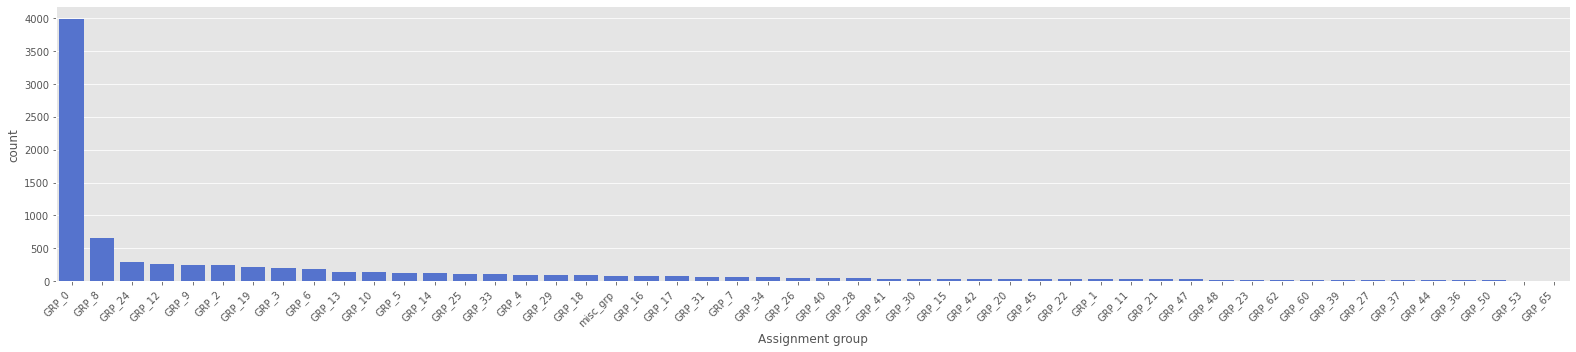

In [4]:
##Pre-Processing label Encoding on  Assignment Group
import seaborn as sns
import matplotlib.pyplot as plt
#add to remove warning for python 3.6 dependency
import warnings
import pandas.util.testing as tm
plt.style.use('ggplot')
%matplotlib inline

descending_order = itTicketDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=itTicketDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Data Cleansing

In [5]:
#Fill 'Decsription' field entries that have null with blank space
itTicketDF['Description'].fillna(value=' ', inplace=True)

In [6]:
from dateutil import parser
def is_valid_date(date_str):
    try:
        parser.parse(date_str)
        return True
    except:
        return False

def clean_data(text):
    text=text.lower()
    text = ' '.join([w for w in text.split() if not is_valid_date(w)])
    text = re.sub(r"received from:",' ',text)
    text = re.sub(r"from:",' ',text)
    text = re.sub(r"to:",' ',text)
    text = re.sub(r"subject:",' ',text)
    text = re.sub(r"sent:",' ',text)
    text = re.sub(r"ic:",' ',text)
    text = re.sub(r"cc:",' ',text)
    text = re.sub(r"bcc:",' ',text)
    #Remove email 
    text = re.sub(r'\S*@\S*\s?', '', text)
    # Remove numbers 
    text = re.sub(r'\d+','' ,text)
    # Remove Non Dictionary character-TODO
    # Remove new line characters 
    text = re.sub(r'\n',' ',text)
    # Remove hashtag while keeping hashtag text
    text = re.sub(r'#','', text)
    #& 
    text = re.sub(r'&;?', 'and',text)
    # Remove HTML special entities (e.g. &amp;)
    text = re.sub(r'\&\w*;', '', text)
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/.*\/\w*', '', text)  
    # Remove characters beyond Readable formart by Unicode:
    text= ''.join(c for c in text if c <= '\uFFFF') 
    text = text.strip()
    # Remove unreadable characters  (also extra spaces)
    text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
    for name in callers:
      namelist = [part for part in name.split()]
      for namepart in namelist: 
          text = text.replace(namepart,'')
          
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(' +', ' ', text)
    text = text.strip()
    return text
  
itTicketDF['Description'] = itTicketDF['Description'].apply(clean_data)

In [7]:
itTicketDF['Description']

0       verified user details employee and manager nam...
1       xd xd xd hello team xd xd my meetings skype me...
2       xd xd xd hi xd xd cannot log on to vpn xd xd best
3                           unable to access hr tool page
4                                             skype error
                              ...                        
8495    xd xd xd good afternoon xd am not receiving th...
8496                             telephony software issue
8497     vip windows password reset for tifpdchb pedxruyf
8498    i am unable to access the machine utilities to...
8499    an mehreren pc lassen sich verschiedene prgram...
Name: Description, Length: 8500, dtype: object

In [8]:
itTicketDF['length']=[len(text) for text in itTicketDF['Description']]
itTicketDF=itTicketDF[itTicketDF['length']>=3]
itTicketDF['Description'] = itTicketDF['Description'].apply(lambda x : " ".join([word for word in x.split() if(len(word)>2)]))

#itTicketDF.drop(['length'],axis=1,inplace= True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
itTicketDF['Description']

0       verified user details employee and manager nam...
1       hello team meetings skype meetings etc are not...
2                                     cannot log vpn best
3                                 unable access tool page
4                                             skype error
                              ...                        
8495    good afternoon not receiving the emails that s...
8496                             telephony software issue
8497     vip windows password reset for tifpdchb pedxruyf
8498    unable access the machine utilities finish the...
8499    mehreren lassen sich verschiedene prgramdntyme...
Name: Description, Length: 8448, dtype: object

## Translation

In [10]:
germanwordlist = ['bitte','nicht','konto','probleme','berechtigung','defekt','mehr','ausgetauscht','rechner', 'drucker','teilweise','freigegeben','genannten','anmeldeaccount',
                  'besprochen','werden','durchwahl','oben','einrichten','zeitwirtschaft','seit','morgens','beheben','keine','zeitbuchungen','vorhanden','dringend','fehler',
                  'werk','anmelde','auftrag','kein','skannen','freundlichen','werkzeuge,','hartstoffe','maste','schutzw','fertigung','immer','sehr','zugriff','freundliche',
                  'geehrter','souzarft','noch','verbindungsherstellung','meldung','erneuten','glich','proben','beilageproben','beilage','auswerten','sinterleitstand','reparar',
                  'reparo','rechner','koenigsee','entregar','atualiza','declara','programdntya','funcionando','preciso','hitacni','grergtger','zugriffsrechte','teamleiter',
                  'abholen','wegen','weit','absender','wenn','abrechnung']
pattern = '|'.join(germanwordlist)

pattern

'bitte|nicht|konto|probleme|berechtigung|defekt|mehr|ausgetauscht|rechner|drucker|teilweise|freigegeben|genannten|anmeldeaccount|besprochen|werden|durchwahl|oben|einrichten|zeitwirtschaft|seit|morgens|beheben|keine|zeitbuchungen|vorhanden|dringend|fehler|werk|anmelde|auftrag|kein|skannen|freundlichen|werkzeuge,|hartstoffe|maste|schutzw|fertigung|immer|sehr|zugriff|freundliche|geehrter|souzarft|noch|verbindungsherstellung|meldung|erneuten|glich|proben|beilageproben|beilage|auswerten|sinterleitstand|reparar|reparo|rechner|koenigsee|entregar|atualiza|declara|programdntya|funcionando|preciso|hitacni|grergtger|zugriffsrechte|teamleiter|abholen|wegen|weit|absender|wenn|abrechnung'

In [11]:
germanDescIndex = itTicketDF[itTicketDF['Description'].str.contains(pattern)].index
germanDescIndex

Int64Index([ 223,  238,  251,  255,  265,  270,  272,  302,  304,  305,
            ...
            8414, 8417, 8419, 8420, 8425, 8427, 8436, 8439, 8467, 8499],
           dtype='int64', length=586)

In [30]:
!pip uninstall googletrans

Found existing installation: googletrans 4.0.0rc1
Uninstalling googletrans-4.0.0rc1:
  Would remove:
    /usr/local/bin/translate
    /usr/local/lib/python3.7/dist-packages/googletrans-4.0.0rc1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/googletrans/*
Proceed (y/n)? y
  Successfully uninstalled googletrans-4.0.0rc1


In [12]:
# since translation done by googletrans & textblob is giving error while using checking & translating every row, just checking the "Description" for german word like 'bitte'

#Install google translator by pip if not installed
!pip install googletrans==3.1.0a0
from googletrans import Translator

def translateIfRequired(x):
    x=str(x)
    translator = Translator()
    if translator.detect(x).lang != 'en':
        translatedText = translator.translate(x).text
    else:
        translatedText = x
    return translatedText

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
from googletrans import Translator
NoneType = type(None)
def translateIfRequired1(x):
  translator = Translator()
  translatedText = translator.translate(x).text
  if type(translatedText) == NoneType:
    return "empty"
  else:
    return translatedText

In [27]:
newlist=[]
for each in germanDescIndex:
  newlist.append(itTicketDF['Description'][each])
print(newlist)

['Hello has happened again, which once again rose and only a blue screen with white script', 'all have connectivity issue between erp and msd crm due certificate renewal azure websites and that certificate not yet updated erp side issue changes data records accounts sales area data partner functions contacts leads are not being processed from erp worked with msd crm and vice versa all environments prod and dev issue start time troubleshooting steps when tryhdty from customer master team reported the issue that prospect account created erp didn come into msd yet erp team observed that the records are still awaiting acknowledgement status which basically means they are not yet delivered received the target system upon some log analysis and trying identify the root cause between erp basis and msd teams been observed that the issue has started production environment since around est observed the same behavior with azure mfg tool and erp logs other non production environments well you can f

In [13]:
for rowId in germanDescIndex:
  itTicketDF['Description'][rowId] = translateIfRequired(itTicketDF['Description'][rowId])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
germanDescIndex_new = itTicketDF[itTicketDF['Description'].str.contains(pattern)].index
germanDescIndex_new
# count=0
# for each in germanDescIndex_new:
#   count+=1
# print(count)

Int64Index([ 238,  874,  914,  932,  995, 1233, 1543, 1572, 1576, 1656, 1737,
            1968, 2076, 2080, 2081, 2084, 2384, 2445, 2541, 2721, 2938, 2952,
            2954, 2991, 3088, 3110, 3139, 3257, 3275, 3431, 3438, 3571, 3585,
            3660, 3703, 3834, 3907, 4027, 4087, 4089, 4147, 4167, 4325, 4335,
            4342, 4461, 4573, 4674, 4704, 4736, 4965, 4970, 5110, 5209, 5448,
            5506, 5693, 5721, 6017, 6052, 6213, 6232, 6336, 6368, 6505, 6750,
            6774, 6776, 6777, 6780, 6829, 6931, 7015, 7028, 7240, 7361, 7429,
            7445, 7565, 7711, 7723, 7782, 7807, 7809, 7832, 7912, 8214, 8216,
            8237, 8436],
           dtype='int64')

## Combine Description and Short Description

In [19]:
itTicketDF.reset_index(drop=True,inplace=True)

itTicketDF['Description'] = itTicketDF['Description'].str.strip()
itTicketDF['Description'] = itTicketDF['Description'].str.lower()

from collections import OrderedDict
itTicketDF['Description']=itTicketDF['Description'].str.split().apply(lambda x:OrderedDict.fromkeys(x).keys()).str.join(' ')
itTicketDF.info()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8448 entries, 0 to 8447
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Description       8448 non-null   object
 1   Assignment group  8448 non-null   object
 2   length            8448 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 198.1+ KB


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Lemmatisation and stop words removal

In [22]:
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger') 

sr = stopwords.words('english')
for i,text in enumerate(itTicketDF['Description']):
  itTicketDF['Description'][i]=" ".join(word for word in text.split(' ') if word not in sr)

# install spacy and plt for gensim  
!pip install -q spacy 
!python -m spacy download en_core_web_sm
import spacy
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp=spacy.load("en_core_web_sm")
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

itTicketDF['Description'] = itTicketDF['Description'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 13.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
itTicketDF['Description'][8232]

'hostname plm conversion production alwaysupservice exe wrong number instance process expect gte find'

# Perform Spell check

In [ ]:
# !pip install pyspellchecker

# from spellchecker import SpellChecker

# def correctSpelling(text):
#     spell = SpellChecker()
#     spell.word_frequency.load_words(['netweaver','-pron-','caas','hostname','unmonitored','activesync','audiocode','isp','apac','skype','callie','worklist','gsc','verizon',
#                                      'firewall','wifi','downloader','uploaded','crm','mms','iphone','rgds','thx','inbox','prefetch','mbps','website','www','inplant','openstage',
#                                      'costcenter','undeliverable','svC','emea','html','reinstall','upload','jpg','signout','malware','cvss','rar','xls','uplink','ziped','uncaught',
#                                      'xlsx','wlan','webpage','uploader','firefox','callback','acct','abap','svchost','webserviceclient','wlc','sid'])
#     wordlist = [word for word in text.split()]
#     misspelled = spell.unknown(wordlist)
#     for incorrect in misspelled:
#         correct = spell.correction(incorrect)
#         text = text.replace(incorrect, correct)
#     return text

# itTicketDF['Description'] = itTicketDF['Description'].apply(correctSpelling)

### Observation:
- Initial thoughts were to combine the short description & description fields so that the a more comrehensive vocabulary is generated. But this caused sentences to have foreign language & english being combined. This became a deterent in language translation. 
- On checking model accuracy we observed neglible difference when 'Shot Description' was included.
- Similar while performing spell check also, it was observed that model accuracy was not improving. Hence decided against doing this considering the huge time taken to perform the task by pyspellchecker. 

# Topic Modeling


1.   Use Sapcy for lemmatistaion 
2.   Use PyLDAvis for the plot to provide good info on clustering.
3.   Use NLTk explicitly (stop word removal)on each Value in text_combined . 
4.   Use bigram model to cluster relevant data together usings genSIM. 



In [24]:
!pip install -q pyLDAvis 

     |████████████████████████████████| 1.7 MB 21.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done


In [26]:
# Gensim
import gensim
import gensim.corpora as corpora
#Remove stemming(snowball stemming) add lemmatistaion using simple_process from gensim 
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
# import pyLDAvis.gensim  # don't skip this 
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [27]:
#to process the simple_process gensim package as input needed as string 
combined_text=itTicketDF.Description.values.tolist()

In [28]:
combined_text[1]

'hello team meeting skype etc appear outlook calendar somebody please advise correct kind'

In [29]:
#Convert  Combined text from each sentense to the words. use of simple_process as it tokenize() internally
#https://radimrehurek.com/gensim/utils.html#gensim.utils.simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(combined_text))

In [30]:
print(data_words[1])

['hello', 'team', 'meeting', 'skype', 'etc', 'appear', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [31]:
# Build the bigram and trigram models
#https://radimrehurek.com/gensim/models/phrases.html
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [32]:
print(bigram_mod[data_words[1]])

['hello', 'team', 'meeting', 'skype', 'etc', 'appear', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [33]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[1]]])

['hello', 'team', 'meeting', 'skype', 'etc', 'appear', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


In [34]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [35]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [36]:
print(data_words_bigrams[1])

['hello', 'team', 'meeting', 'skype', 'etc', 'appear', 'outlook', 'calendar', 'somebody', 'please', 'advise', 'correct', 'kind']


##### WordCloud usage 

In [37]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [38]:
wordclouds=' '.join(map(str, data_words_bigrams)) 

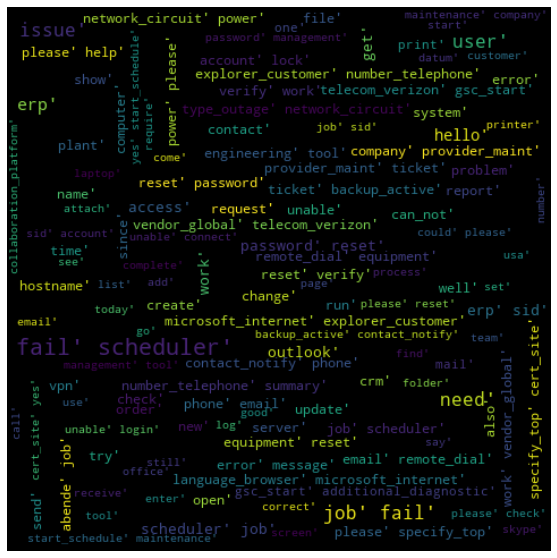

In [39]:
wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(wordclouds)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


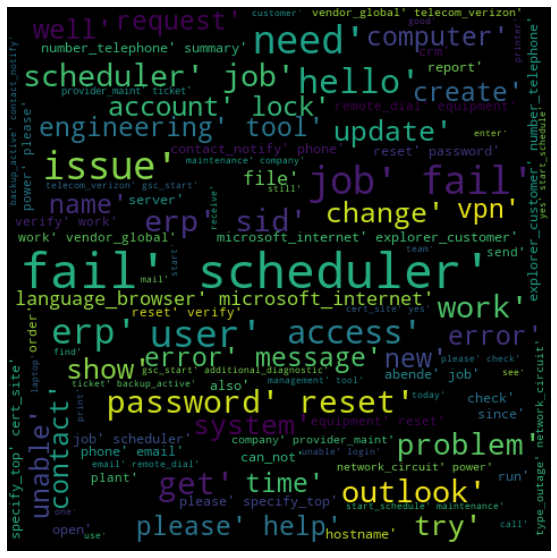

In [40]:
#check for the word count 100)
wordcloud_2 = WordCloud(width=480, height=480, max_words=100).generate(wordclouds)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud_2, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

In [41]:
#Copying to new dataframe to create wordclouds on target class

new_df = itTicketDF.copy()
new_df['words'] = data_words_bigrams
new_df

Description Assignment group  \
0     verify user detail employee manager name check...            GRP_0   
1     hello team meeting skype etc appear outlook ca...            GRP_0   
2                                  can not log vpn good            GRP_0   
3                               unable access tool page            GRP_0   
4                                           skype error            GRP_0   
...                                                 ...              ...   
8443  good afternoon receive email send mail please ...           GRP_29   
8444                           telephony software issue            GRP_0   
8445       vip windows password reset tifpdchb pedxruyf            GRP_0   
8446  unable access machine utility finish drawer ad...           GRP_62   
8447  several different prgramdntyme can not open ar...         misc_grp   

      length                                              words  
0        204  [verify, user, detail, employee, manager, name...  
1        155  [hello, team, meeting, skype, etc, appear, out...  
2         49                          [can_not, log, vpn, good]  
3         29                       [unable, access, tool, page]  
4         11                                     [skype, error]  
...      ...                                                ...  
8443     100  [good_afternoon, receive, email, send, mail, p...  
8444      24                        [telephony_software, issue]  
8445      48  [vip, windows, password, reset, tifpdchb, pedx...  
8446     102  [unable, access, machine, utility, finish, dra...  
8447      76  [several, different, prgramdntyme, can_not, op...  

[8448 rows x 4 columns]

In [42]:
#Sorting based on frequency of target class Assignment group

value = new_df['Assignment group'].value_counts().sort_values(ascending=False).index
value

Index(['GRP_0', 'GRP_8', 'GRP_24', 'GRP_12', 'GRP_9', 'GRP_2', 'GRP_19',
       'GRP_3', 'GRP_6', 'GRP_13', 'GRP_10', 'GRP_5', 'GRP_14', 'GRP_25',
       'GRP_33', 'GRP_4', 'GRP_29', 'GRP_18', 'misc_grp', 'GRP_16', 'GRP_17',
       'GRP_7', 'GRP_31', 'GRP_34', 'GRP_26', 'GRP_40', 'GRP_28', 'GRP_41',
       'GRP_15', 'GRP_42', 'GRP_20', 'GRP_45', 'GRP_1', 'GRP_22', 'GRP_11',
       'GRP_21', 'GRP_47', 'GRP_62', 'GRP_23', 'GRP_60', 'GRP_39', 'GRP_27',
       'GRP_30', 'GRP_37', 'GRP_44', 'GRP_36', 'GRP_50', 'GRP_53', 'GRP_65',
       'GRP_48'],
      dtype='object')

In [43]:
# Creating a function for wordcloud
def wordcloud_grp(f, x):
    wordclouds_0=' '.join(map(str, f))

    wc = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10, max_words=50).generate(wordclouds_0)
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Most common 50 words of {}".format(x))
    plt.margins(x=0, y=0)
    plt.show()

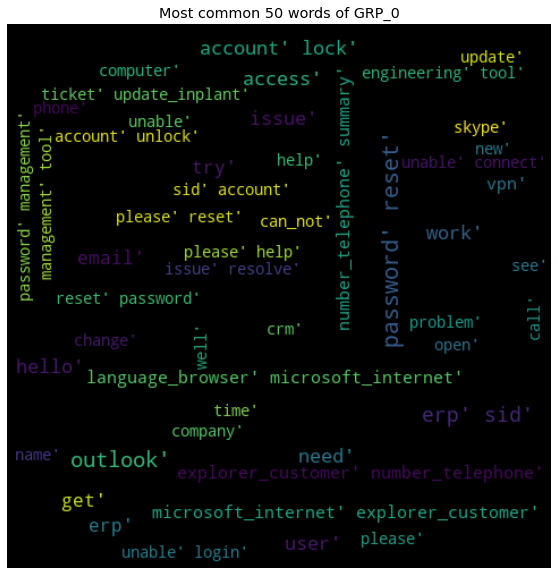

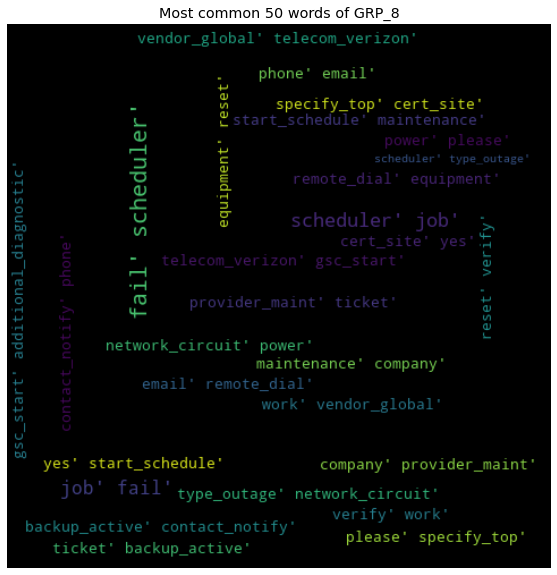

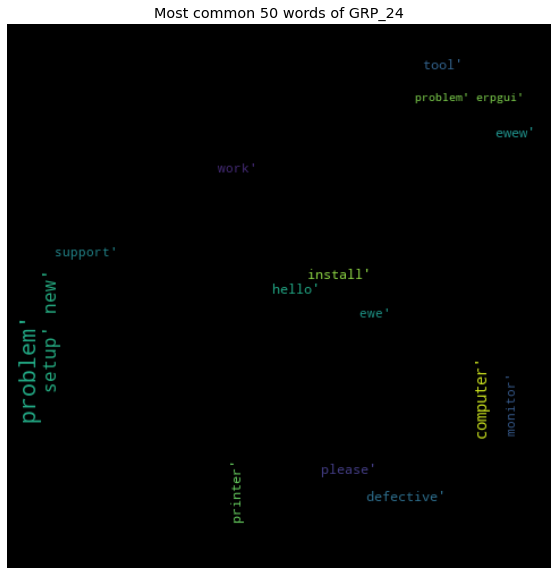

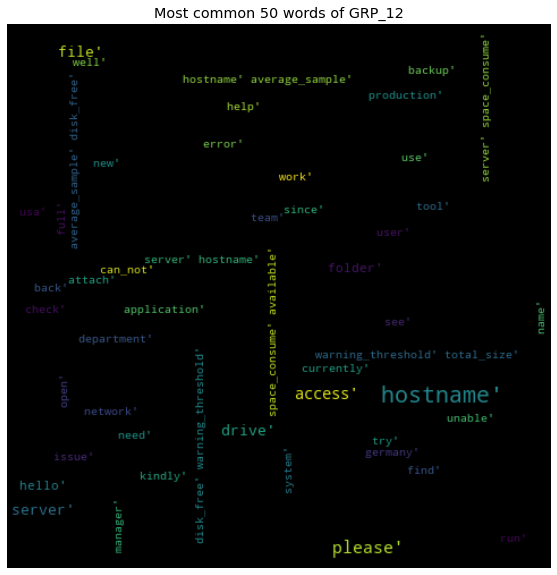

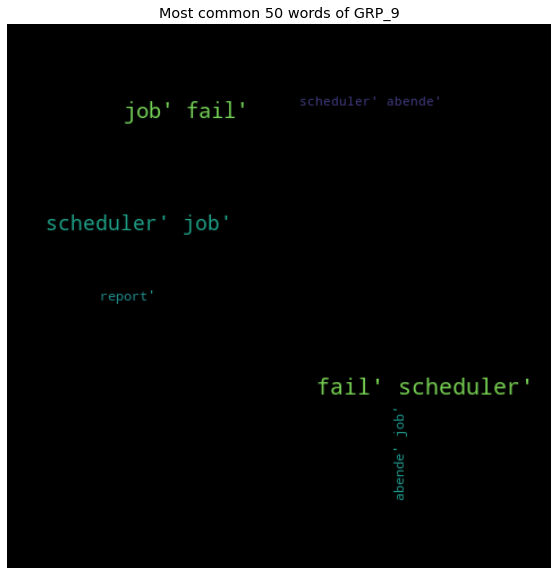

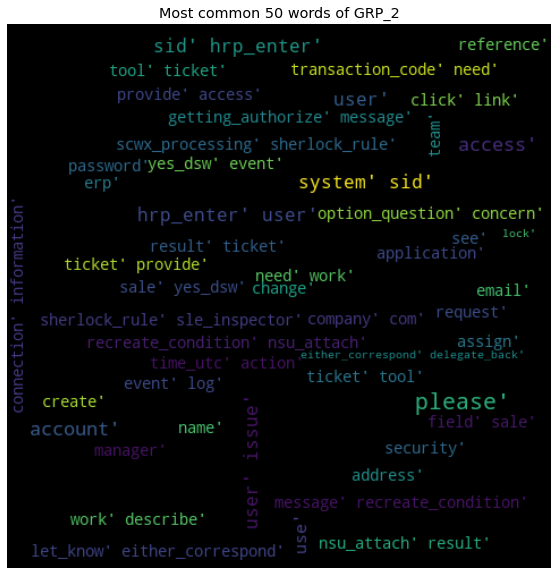

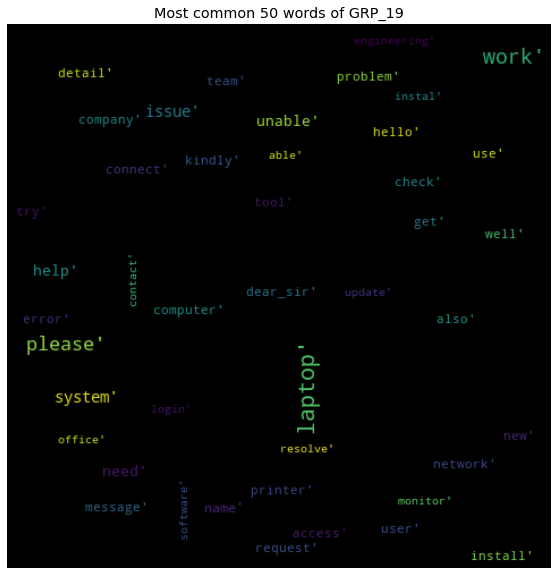

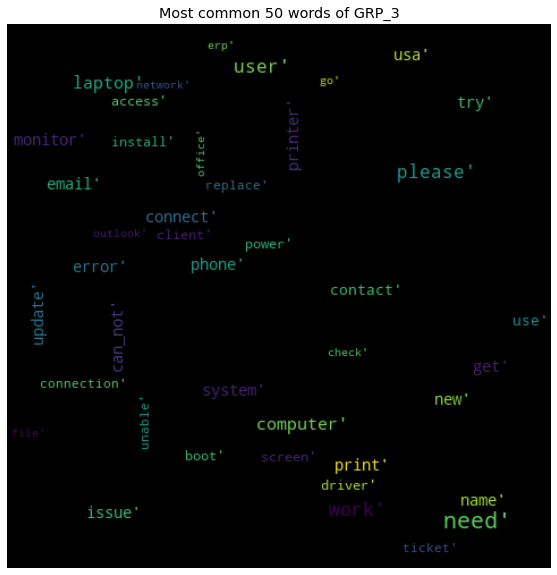

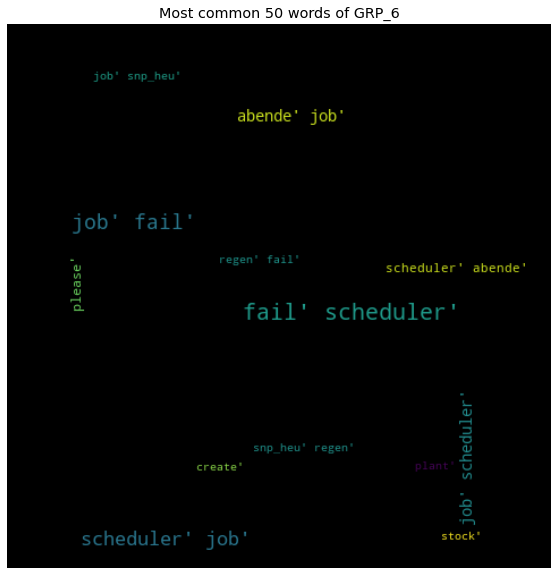

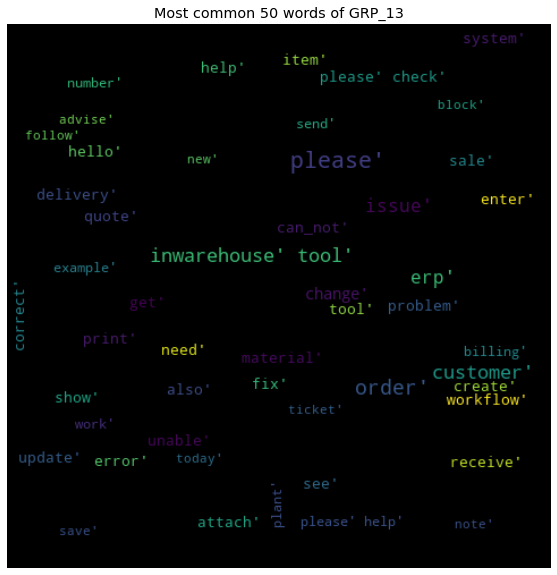

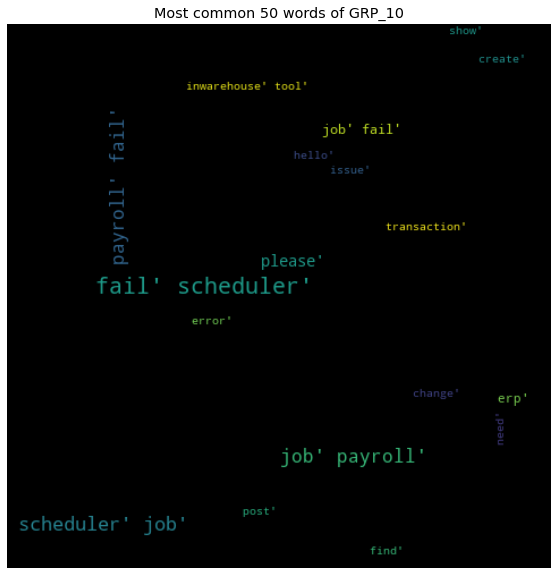

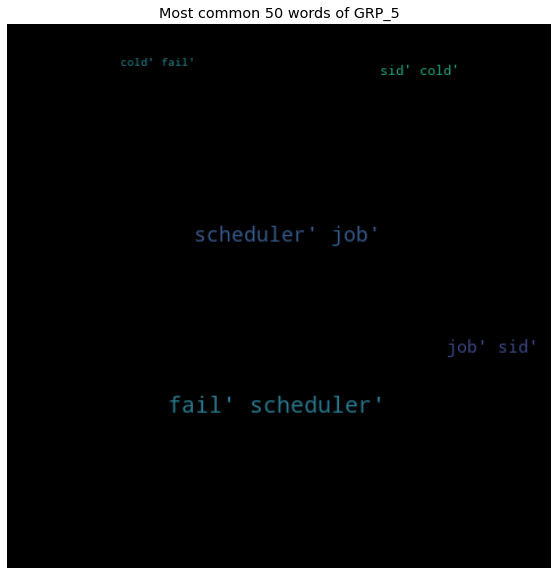

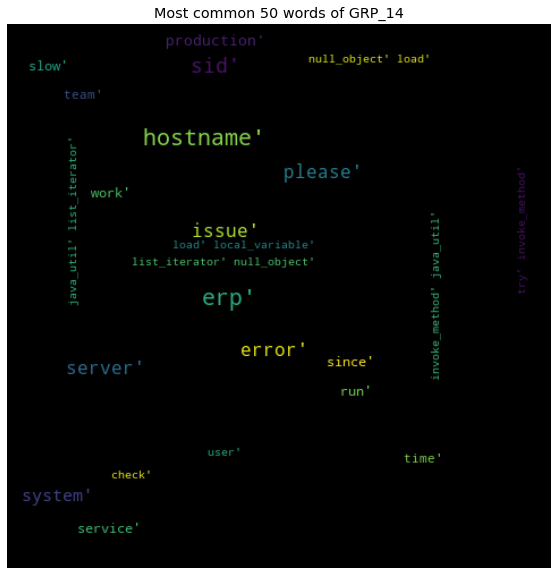

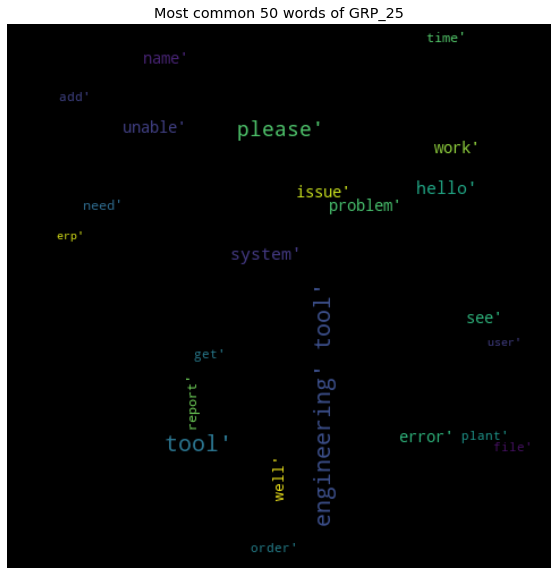

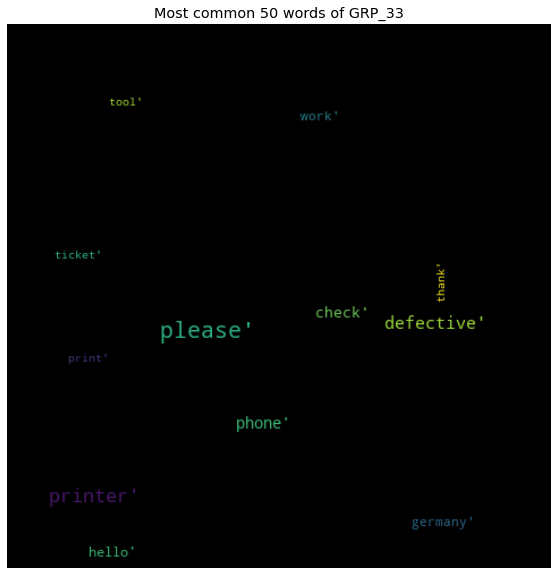

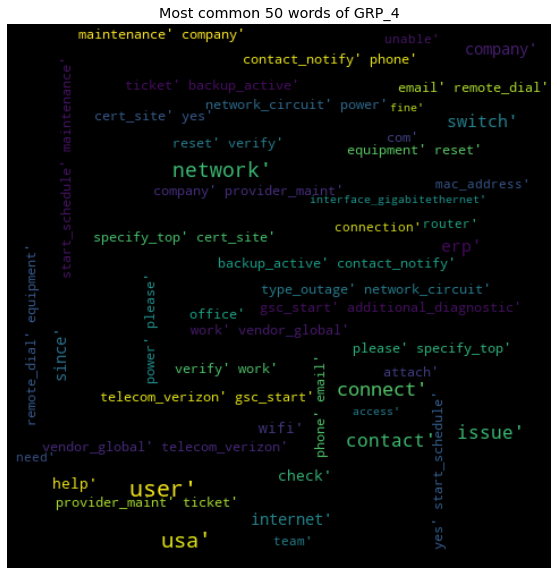

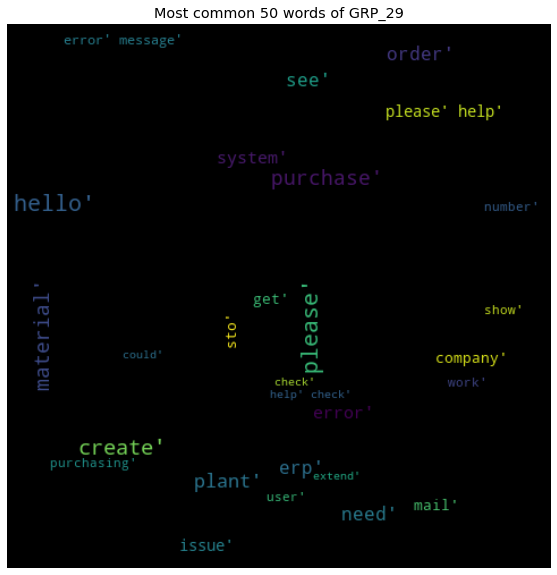

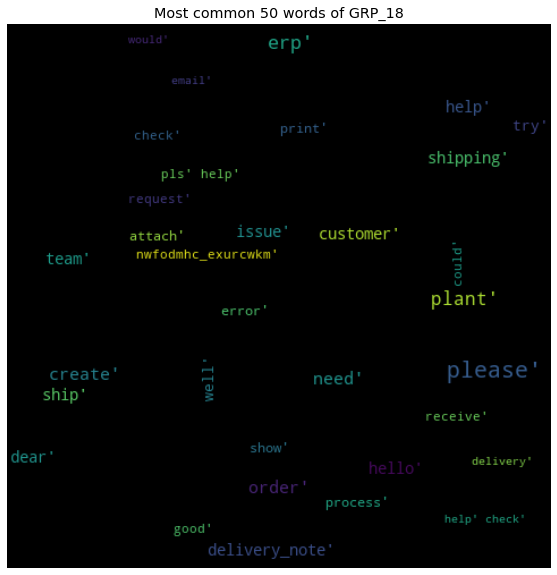

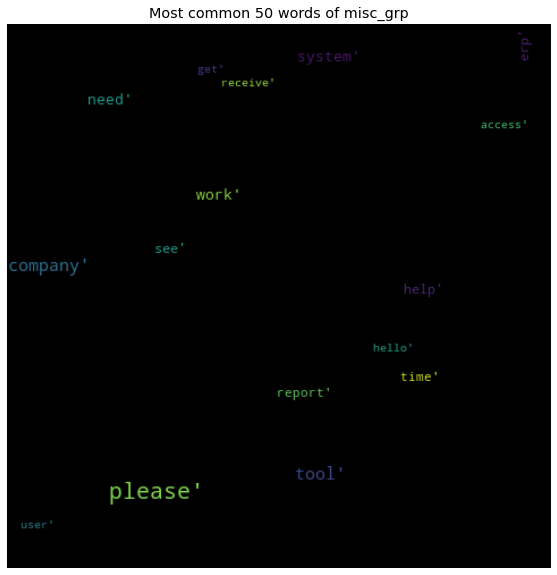

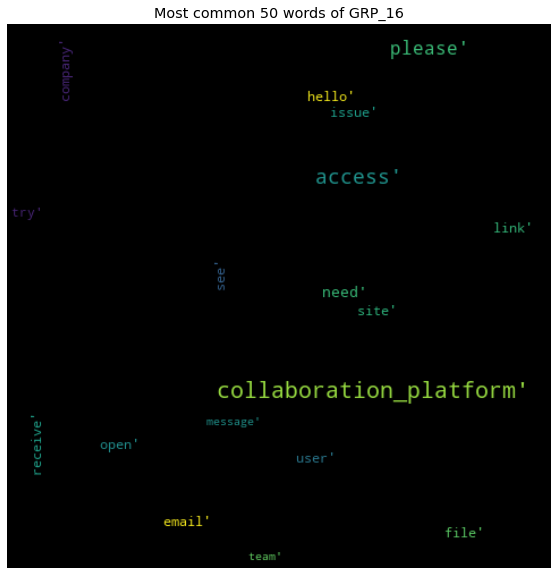

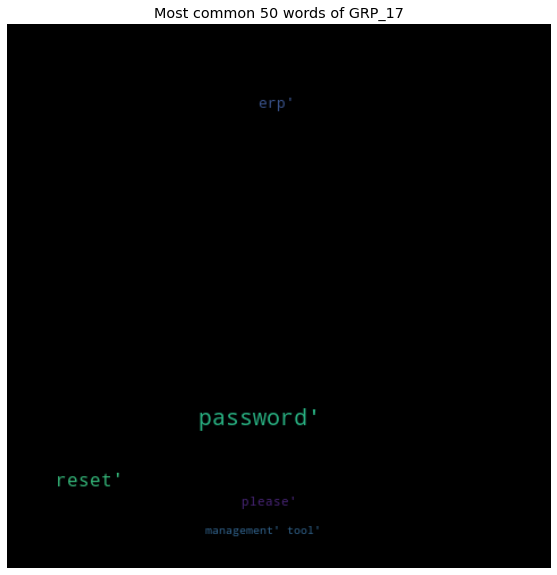

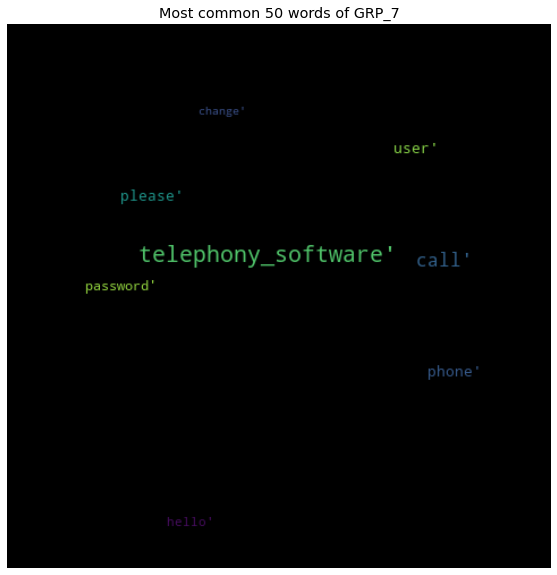

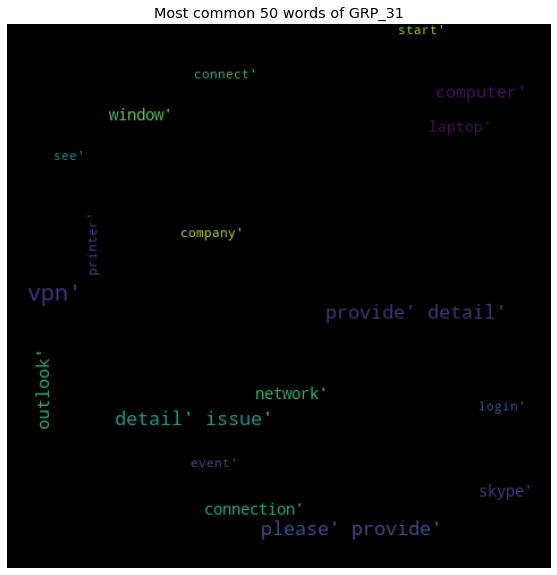

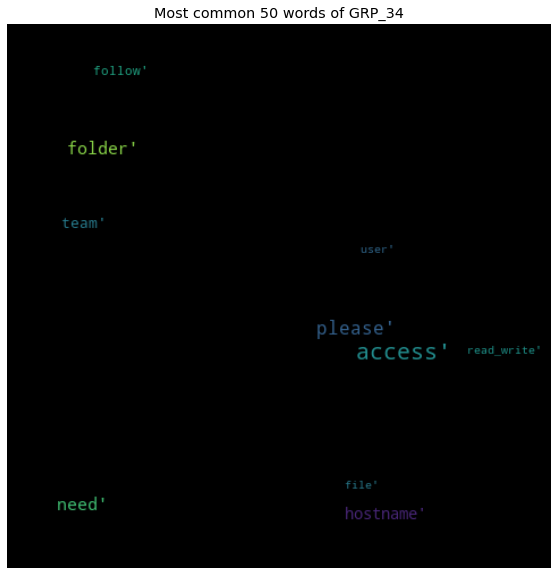

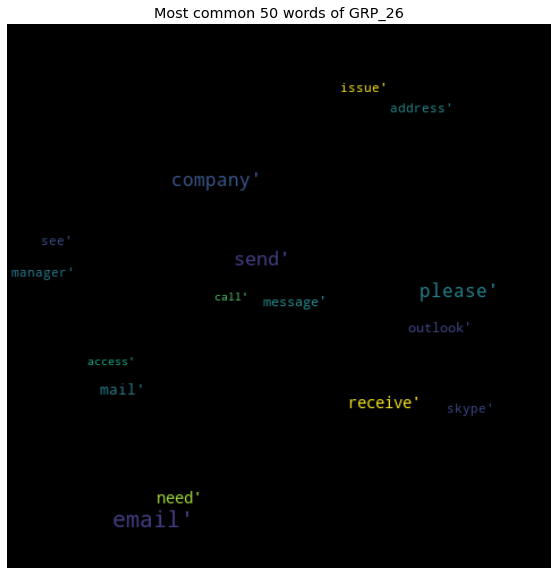

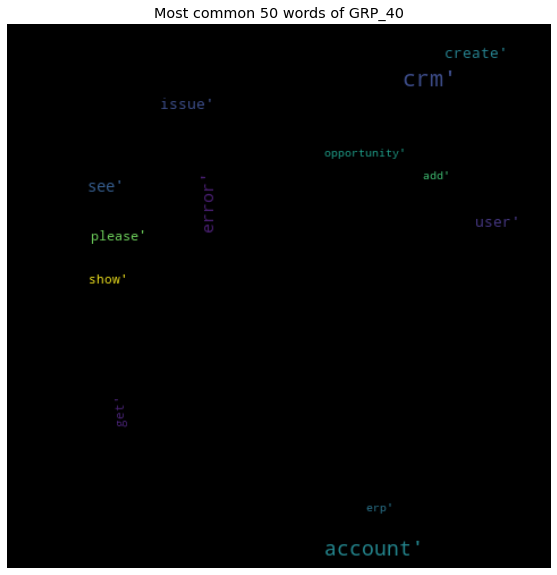

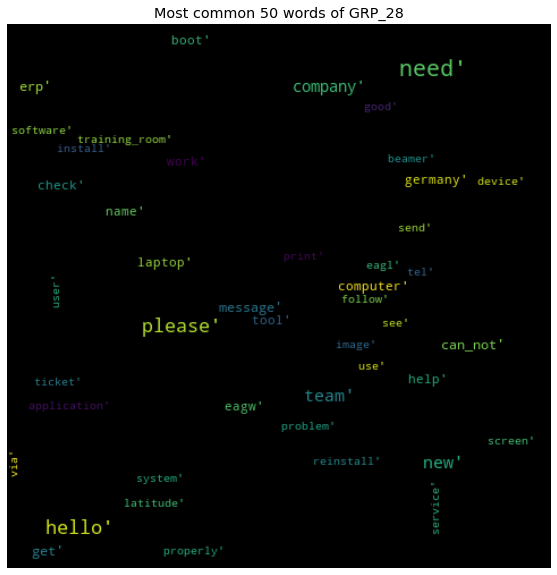

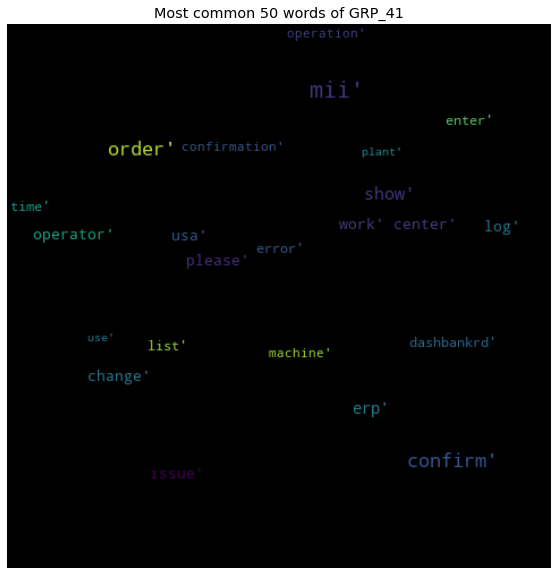

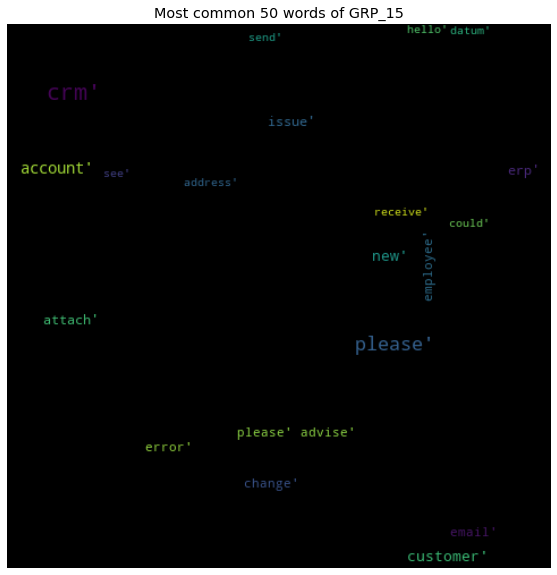

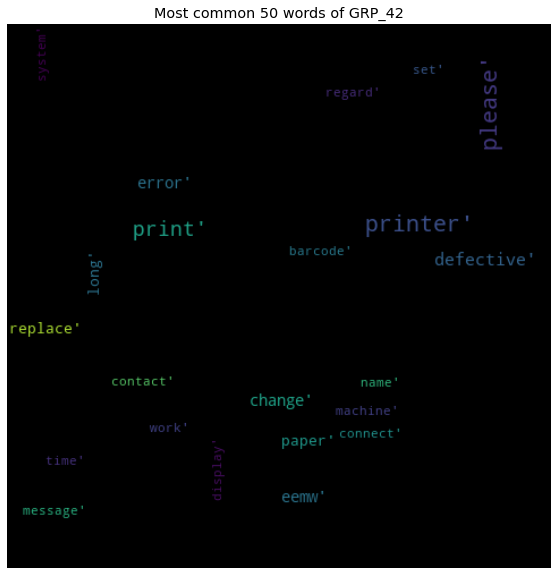

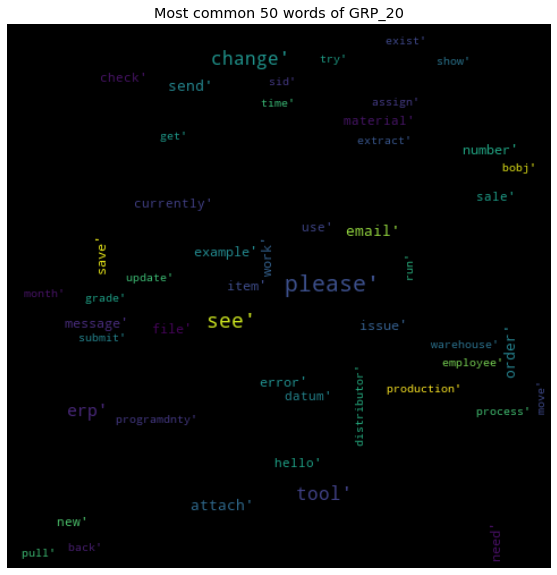

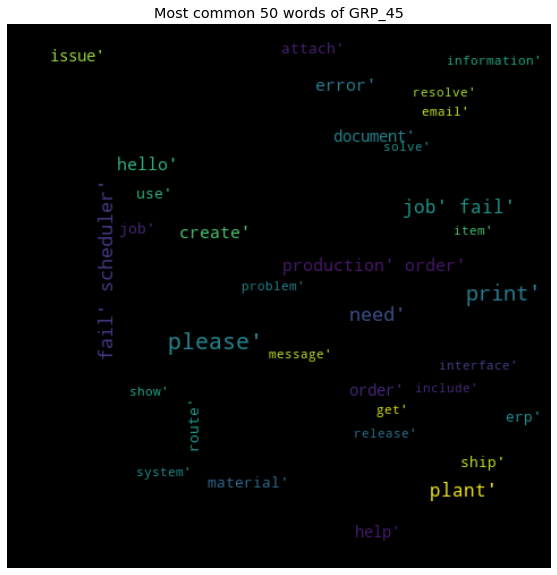

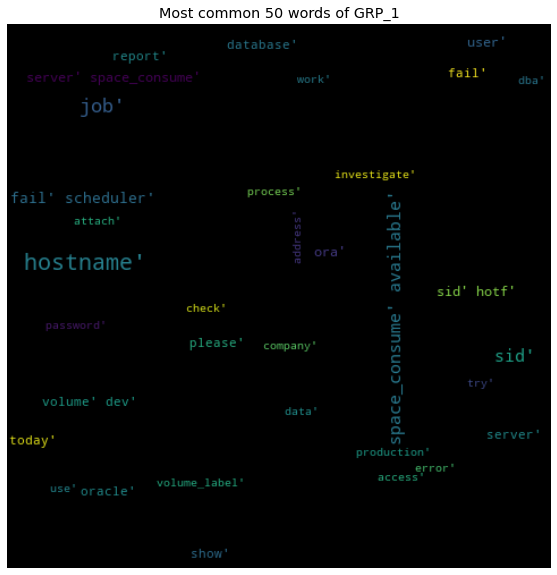

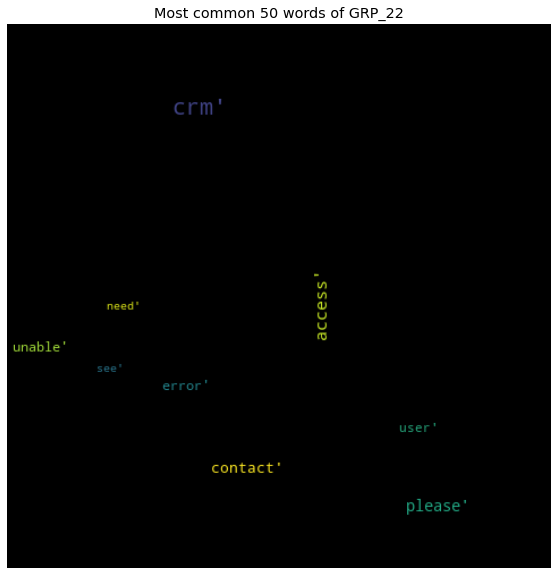

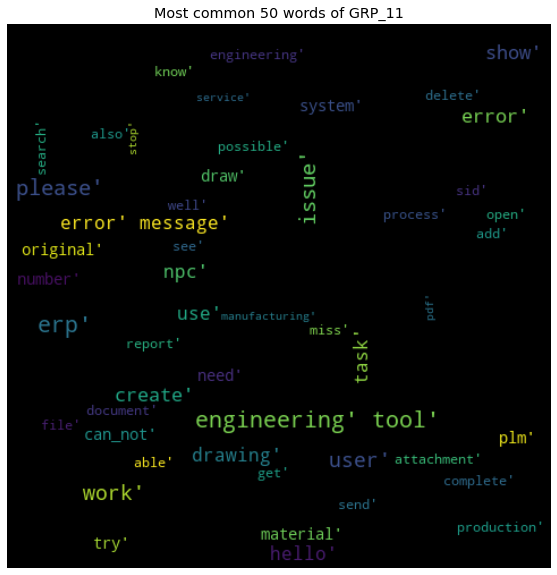

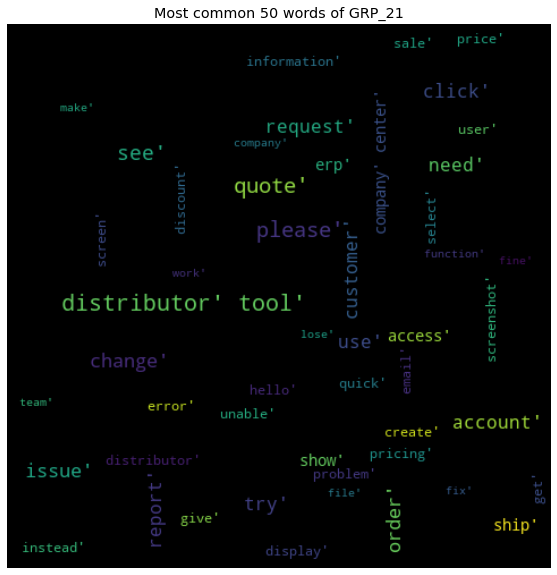

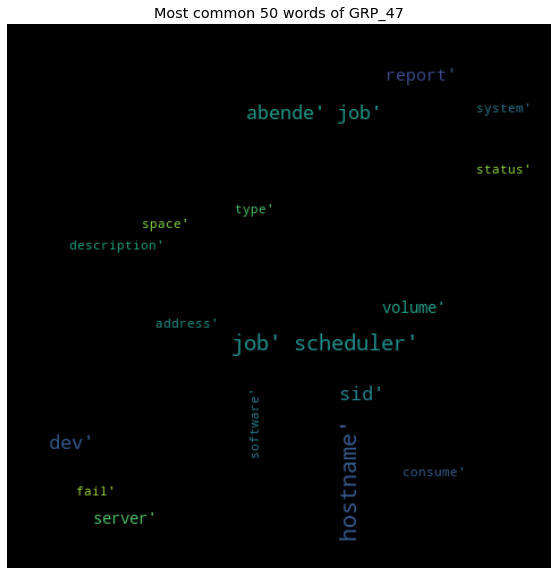

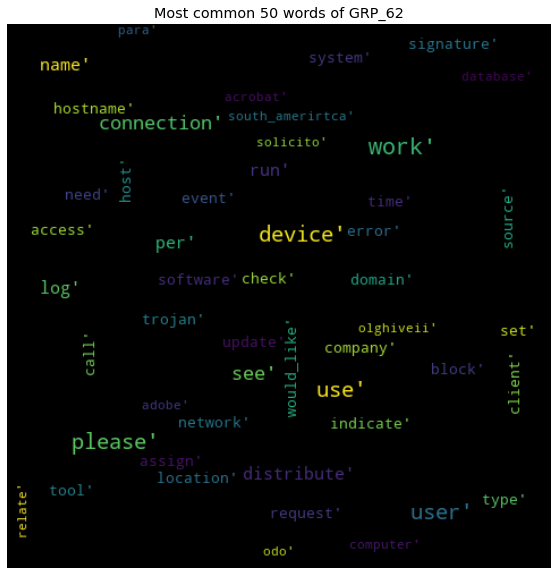

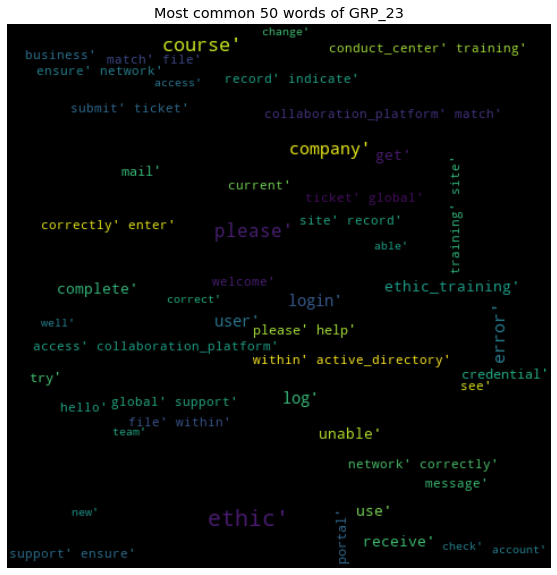

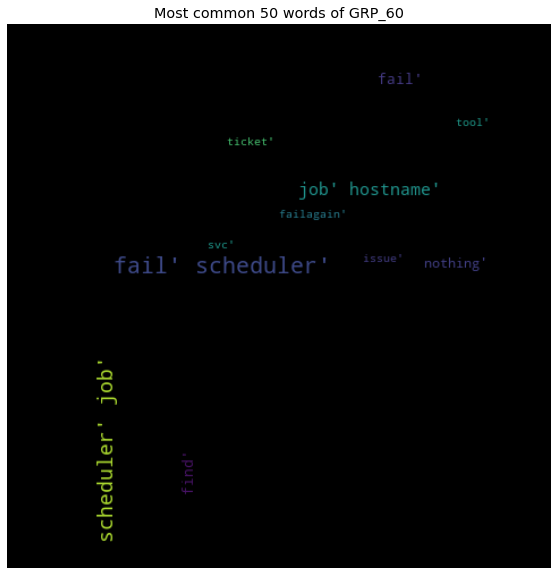

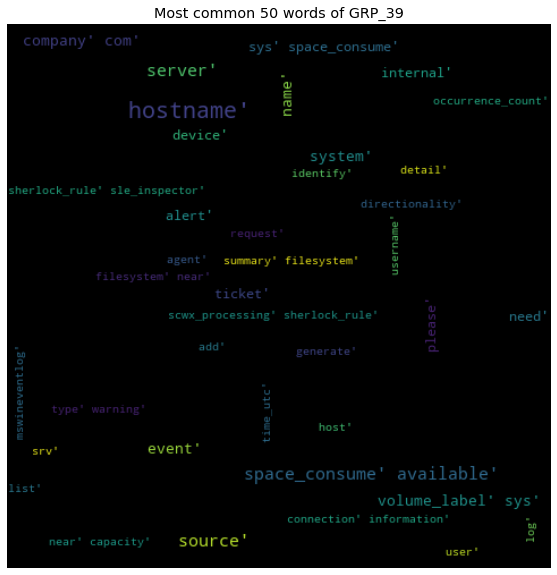

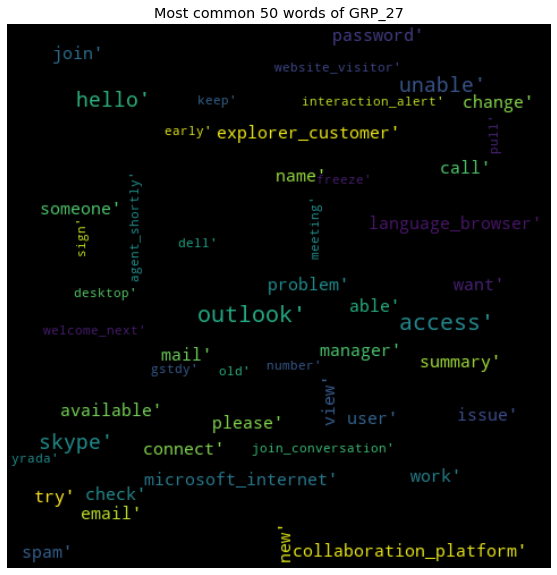

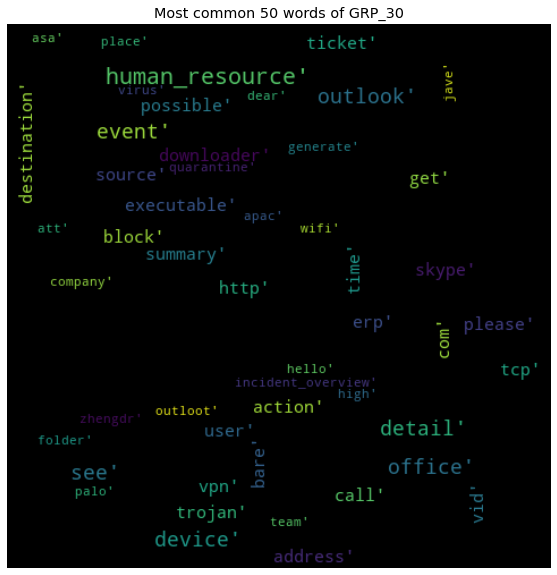

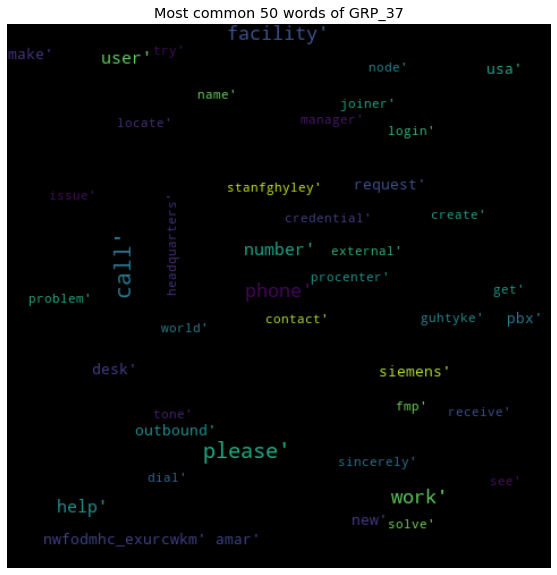

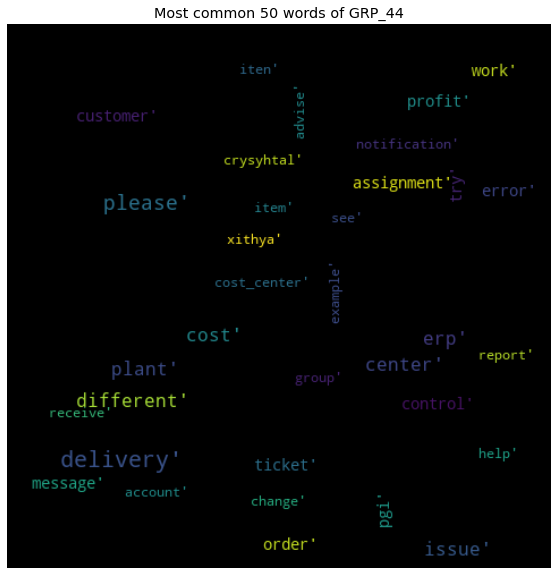

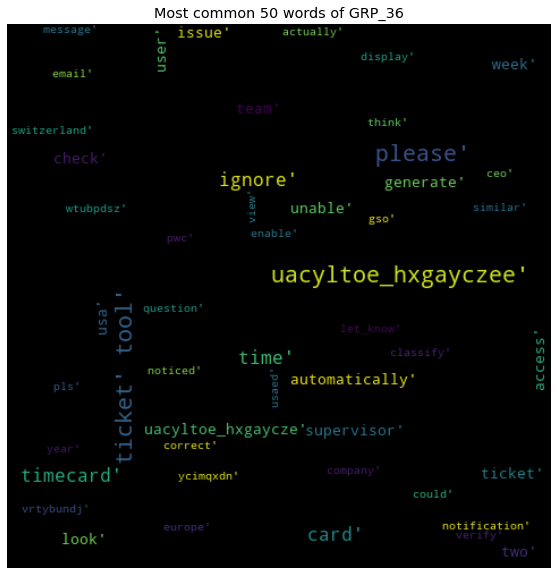

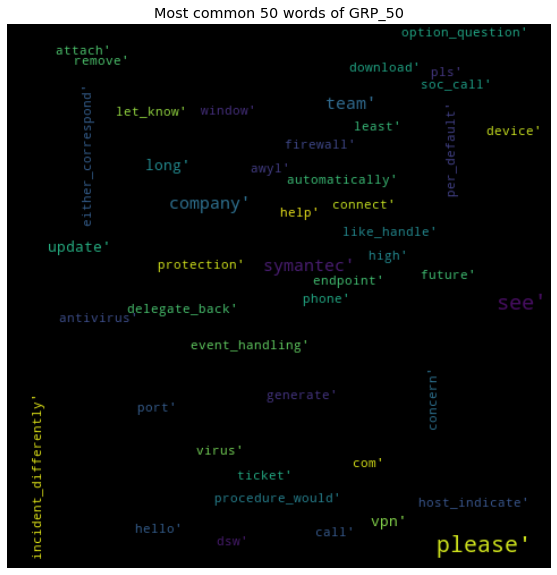

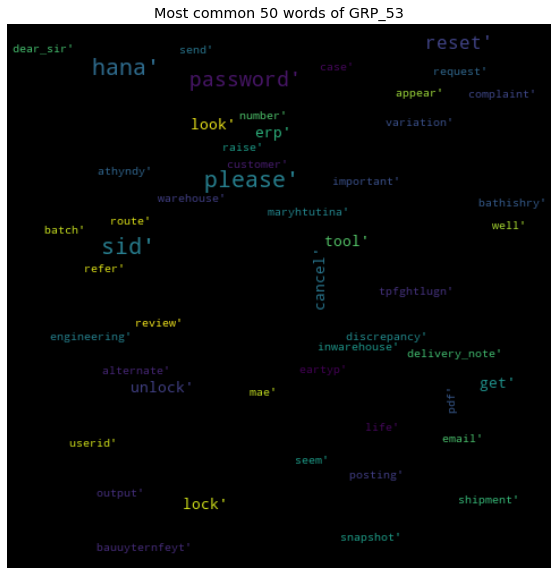

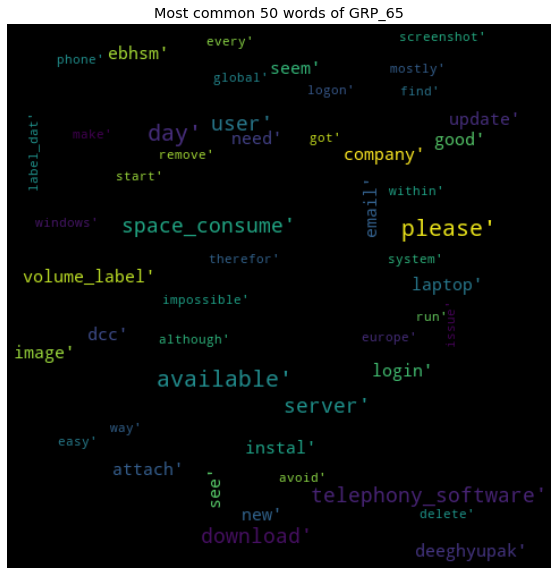

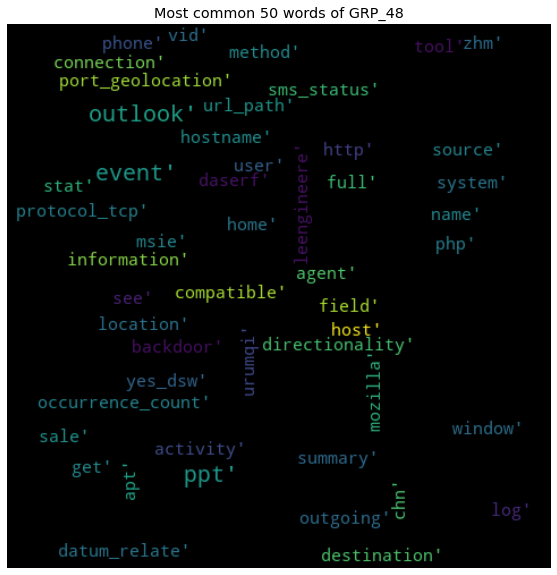

In [44]:
#for loop to pass the top 50 Assignment groups

for i in range(50):

    Grp = new_df[new_df ['Assignment group'] == value[i]]
    Grp = Grp['words']
    wordcloud_grp(Grp,value[i])

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus from post clean data 
texts = data_words_bigrams

# Term Document Frequency and Bag of words 
#https://radimrehurek.com/gensim/corpora/dictionary.html
corpus = [id2word.doc2bow(text) for text in texts]

In [46]:
# View not human readable 
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1)]]


In [47]:
#possible human redable 
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('able', 1), ('advise', 1), ('caller_confirm', 1), ('check', 2), ('detail', 1), ('employee', 1), ('issue', 1), ('login', 1), ('manager', 1), ('name', 1), ('password', 1), ('reset', 1), ('resolve', 1), ('user', 1), ('verify', 1)]]


Bag of word model is working with bi gram and trigram model getting more insight from the words and its frequencey in document 1  . 


1.   Caller_confirmed occur once in document 1 
2.   check occur twice  in document 1 



In [48]:
# Build LDA model
#https://radimrehurek.com/gensim/models/ldamodel.html
lda_model = LdaModel(corpus=corpus,id2word=id2word,num_topics=7,random_state=200,update_every=1,chunksize=800,passes=10,alpha='auto',per_word_topics=True)

In [49]:
#top 7 topics from the corpus 
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"request" + 0.031*"name" + 0.024*"summary" + 0.018*"skype" + '
  '0.016*"language_browser" + 0.016*"number_telephone" + '
  '0.016*"microsoft_internet" + 0.016*"explorer_customer" + 0.014*"hostname" + '
  '0.012*"user"'),
 (1,
  '0.009*"setup" + 0.008*"know" + 0.007*"software" + 0.006*"hostname" + '
  '0.006*"list" + 0.006*"action" + 0.006*"company" + 0.006*"code" + '
  '0.006*"destination" + 0.005*"new"'),
 (2,
  '0.032*"please" + 0.015*"hello" + 0.014*"error" + 0.012*"need" + '
  '0.012*"help" + 0.011*"access" + 0.011*"get" + 0.010*"see" + 0.010*"ticket" '
  '+ 0.010*"work"'),
 (3,
  '0.136*"job" + 0.127*"scheduler" + 0.089*"fail" + 0.056*"abende" + '
  '0.030*"sid" + 0.020*"hostname" + 0.008*"cold" + 0.007*"tool" + '
  '0.006*"transaction" + 0.006*"rad"'),
 (4,
  '0.028*"phone" + 0.028*"power" + 0.028*"work" + 0.027*"please" + '
  '0.026*"email" + 0.025*"yes" + 0.024*"company" + 0.024*"ticket" + '
  '0.022*"verify" + 0.022*"equipment"'),
 (5,
  '0.048*"unable" + 0.026*

In [50]:
texts=data_words_bigrams
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -7.264465833369002

Coherence Score:  0.5318254645992545


In [51]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

AttributeError: ignored

# Provide info to business 

In [52]:
# add a deep copy to another dataframe itTicketDF  to other DF
data =  itTicketDF.copy()
data['num_words'] = data.Description.apply(lambda x : len(x.split()))
data.describe().transpose()

count        mean         std  min   25%   50%    75%     max
length     8448.0  148.937145  328.643028  3.0  35.0  61.0  156.0  6860.0
num_words  8448.0   11.855705   18.547662  0.0   3.0   6.0   14.0   434.0

In [53]:
bins=[0,50,75, np.inf]
data['bins']=pd.cut(data.num_words, bins=[0,100,300,500,800, np.inf], labels=['0-100', '100-300', '300-500','500-800' ,'>800'])
word_distribution = data.groupby('bins').size().reset_index().rename(columns={0:'counts'})

In [54]:
word_distribution

bins  counts
0    0-100    8340
1  100-300      33
2  300-500       7
3  500-800       0
4     >800       0

Text(0.5, 1.0, 'Word distribution per bin')

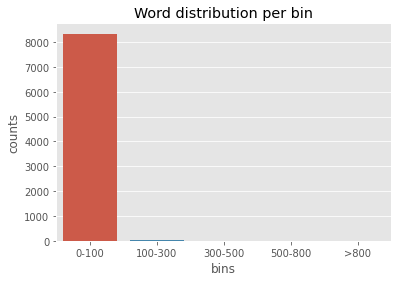

In [55]:
sns.barplot(x='bins', y='counts', data=word_distribution).set_title("Word distribution per bin")

**Observation**
*   Most of the descrption of the problems raised by callers are short with in 0-100 words
*   Few items are with bit descriptive 



# Generate Dataset for createing 2 models
- Model 1 : Group 0 & all other groups combined to "other"
- Model 2 : Group 0 removed & only includes other groups
- Model 1 will be use dto classing group 0. If not found to be Group 0, we can classify using Model 2.

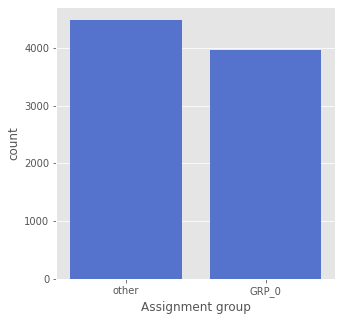

In [56]:
# Create the Dataset for classifying GRP_0
itTicketGRP0DF = itTicketDF.copy()
itTicketGRP0DF['Assignment group']=itTicketGRP0DF['Assignment group'].apply(lambda x : 'other' if x != 'GRP_0'  else x)

descending_order = itTicketGRP0DF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(5,5))
sns.countplot(x='Assignment group', data=itTicketGRP0DF, color='royalblue',order=descending_order)

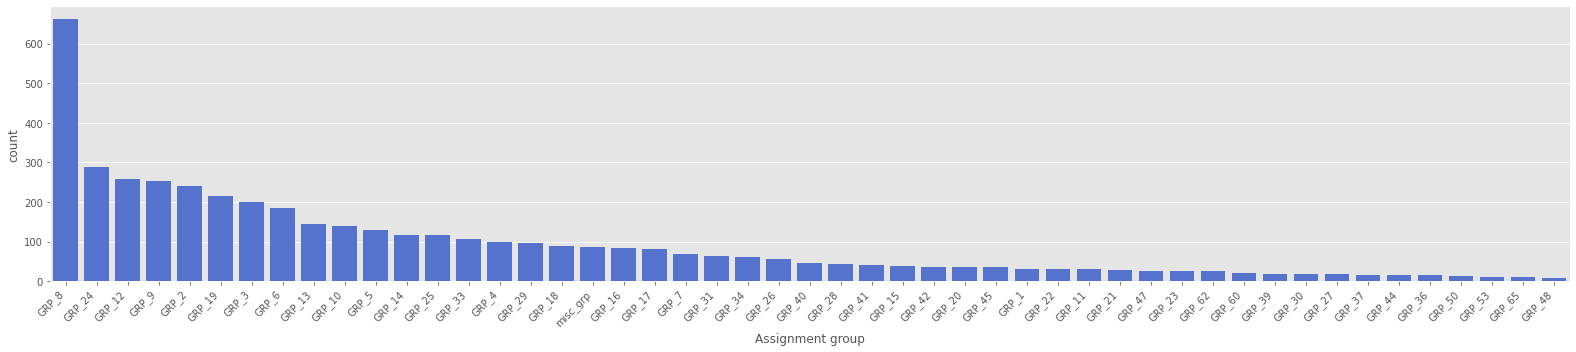

In [57]:
#Create Dataset for 'others' i.e all groups which is not part of GRP_0
itTicketOthersDF = itTicketDF[itTicketDF['Assignment group'] != 'GRP_0']

descending_order = itTicketOthersDF['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Observation
- There is high imbalance within the other group

In [58]:
maxOthers = itTicketOthersDF['Assignment group'].value_counts().max()
maxOthers

661

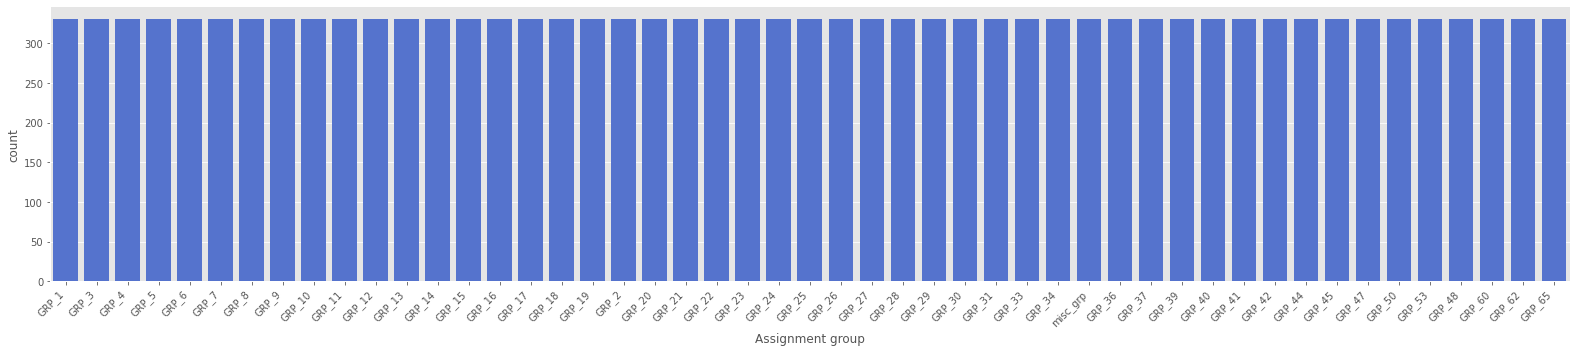

In [59]:
# Treat the imbalnce in the 'other' dataset by resampling
from sklearn.utils import resample
itTicketOthersDF_resampled = itTicketOthersDF[0:0]
for grp in itTicketOthersDF['Assignment group'].unique():
    itTicketGrpDF = itTicketOthersDF[itTicketOthersDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers/2), random_state=123)
    itTicketOthersDF_resampled = itTicketOthersDF_resampled.append(resampled)

otherGrpsResampled = pd.concat([itTicketGRP0DF,itTicketOthersDF_resampled])
otherGrpsResampled.reset_index(inplace=True)

descending_order = itTicketOthersDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketOthersDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

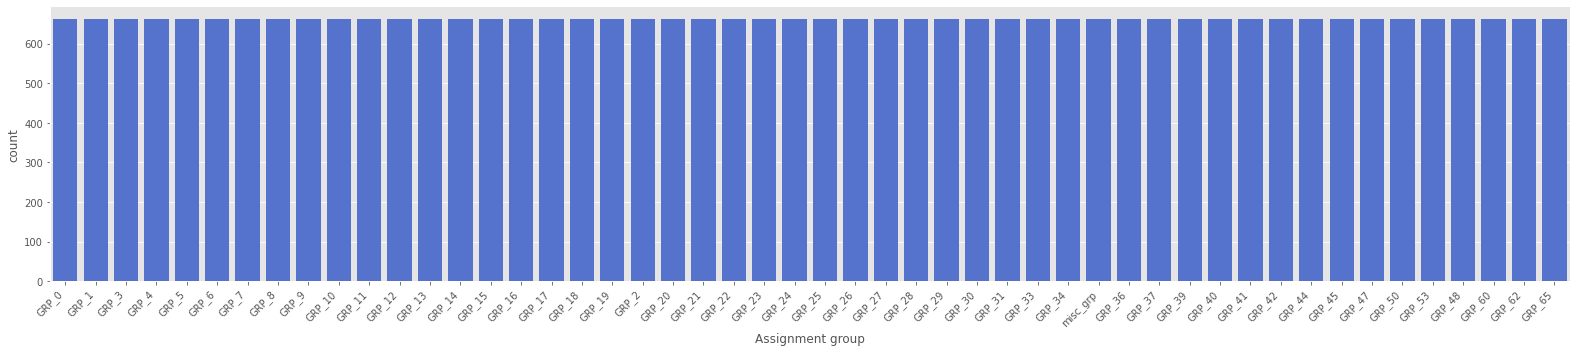

In [60]:
# Treat the imbalnce in the itTicketDF dataset by resampling to 661.This is for us to try creating a single model which use the whiole dataset & verify the performance
itTicketDF_resampled = itTicketDF[0:0]
for grp in itTicketDF['Assignment group'].unique():
    itTicketGrpDF = itTicketDF[itTicketDF['Assignment group'] == grp]
    resampled = resample(itTicketGrpDF, replace=True, n_samples=int(maxOthers), random_state=123)
    itTicketDF_resampled = itTicketDF_resampled.append(resampled)

descending_order = itTicketDF_resampled['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#add code to rotate the labels
ax=sns.countplot(x='Assignment group', data=itTicketDF_resampled, color='royalblue')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Label Encoding 'Assignment group' target class 


In [61]:
from sklearn import preprocessing
def labelencoder(dataframe) : 
  label_encoder = preprocessing.LabelEncoder() 
  dataframe= label_encoder.fit_transform(dataframe)
  grp_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
  return dataframe,grp_mapping

#itTicketGRP0DF['Assignment group'] , grp_mapping_grp0= labelencoder(itTicketGRP0DF['Assignment group'])
#itTicketOthersDF_resampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(itTicketOthersDF_resampled['Assignment group'])
otherGrpsResampled['Assignment group'] , grp_mapping_others_resampled= labelencoder(otherGrpsResampled['Assignment group'])
itTicketDF_resampled['Assignment group'] , grp_mapping_all_resampled= labelencoder(itTicketDF_resampled['Assignment group'])
itTicketDF['Assignment group'],grp_mapping_all_raw = labelencoder(itTicketDF['Assignment group'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


# Modelling

In [62]:
from gensim.models import Word2Vec
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D,GRU,Conv1D,MaxPooling1D
from tensorflow.keras.models import Model, Sequential
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [63]:
# Add Function to capture results from each model 
import operator
def captureData(dataframe,modelHistory,modelName,descriptions,index_df,resetData):
  if resetData == 1:
    tempResultsDf=pd.DataFrame()
    dataframe=pd.DataFrame()
  else:
    index, acc_value = max(enumerate(modelHistory.history['val_accuracy']), key=operator.itemgetter(1))
    tempResultsDf= pd.DataFrame(
      {'model':[modelName], 
      'val_accuracy': [acc_value],
      'val_loss':[modelHistory.history['val_loss'][index]],
      'loss':[modelHistory.history['loss'][index]],
      'accuracy':[modelHistory.history['accuracy'][index]],
      'descriptions':[descriptions]},index={str(index_df)})
    dataframe = pd.concat([dataframe,tempResultsDf])
    dataframe = dataframe[['model','val_accuracy' ,'val_loss','loss','accuracy','descriptions']] 
  return dataframe

def capturePrediction(dataframe,modelName,descriptions,index_df,pred_accuracy,resetData):
  if resetData == 1:
    tempResultsDf=pd.DataFrame()
    dataframe=pd.DataFrame()
  else:
    tempResultsDf= pd.DataFrame(
      {'model':[modelName], 
      'Pred_Accuracy' : [pred_accuracy],
      'descriptions':[descriptions]},index={str(index_df)})
    dataframe = pd.concat([dataframe,tempResultsDf])
    dataframe = dataframe[['model','Pred_Accuracy','descriptions']] 
  return dataframe


## Word2Vec embedding 

In [64]:
sentences = [line.split(' ') for line in itTicketDF['Description']]
word2vec = Word2Vec(sentences=sentences,min_count=1)
word2vec.wv.save_word2vec_format(project_path+ 'word2vec_vector.txt')

In [65]:
# load the whole embedding into memory
embeddings_index = dict()
f = open(project_path+'word2vec_vector.txt')

for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 9244 word vectors.


In [66]:
maxlen = 300
numWords=9000
epochs = 10

In [67]:
results=pd.DataFrame()
pred_results = pd.DataFrame()

### LSTM Model

In [70]:
class LstmModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    lstm=Bidirectional(LSTM(128))(embed)
    drop=Dropout(0.3)(lstm)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    self.model.summary()
    plot_model(self.model,to_file="LSTM_Model.jpg")

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))

    return model_history,self.model

  def prediction(self):
      
     pred = self.model.predict(self.X_test)
     pred = [i.argmax() for i in pred]
     accuracy = metrics.accuracy_score(self.y_test, pred)
     print("Accuracy of the model :",metrics.accuracy_score(self.y_test, pred))
     return accuracy

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [71]:
# Check how the LSTM Model perform with the cleansed data
lstmModelRawData = LstmModel()
lstmModelRawData_history, model = lstmModelRawData.train(itTicketDF,100,epochs)
rawData_accuracy = lstmModelRawData.prediction()

Number of Samples: 8448
Number of Labels:  8448
Number of train Samples: 6758
Number of val Samples: 1690
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          900100    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dense_1 (Dense)   

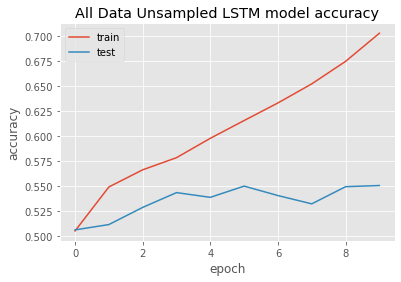

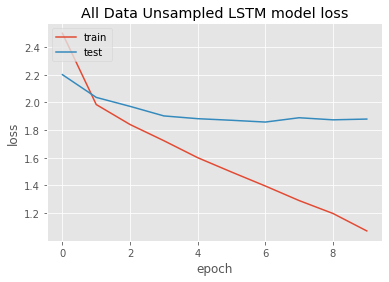

In [72]:
lstmModelRawData.plotModelAccuracy(lstmModelRawData_history, 'All Data Unsampled LSTM')

In [73]:
from tensorflow import keras
from keras.models import load_model
model.save('lstm-model-1.h5')

In [74]:
# Check how the LSTM Model perform with all the data which is cleansed & resampled to 661 to make the target balance
lstmModelAllDataResampled = LstmModel()
lstmModelAllDataResampled_history, model = lstmModelAllDataResampled.train(itTicketDF_resampled,100,epochs)
resampled_accuracy = lstmModelAllDataResampled.prediction()


Number of Samples: 33050
Number of Labels:  33050
Number of train Samples: 26440
Number of val Samples: 6610
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          900100    
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               25700     
                                                                 
 dense_3 (Dense)

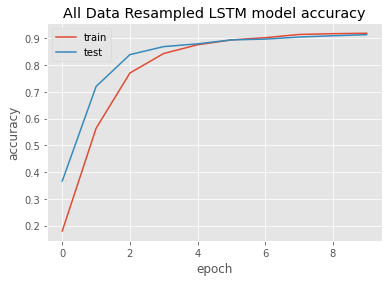

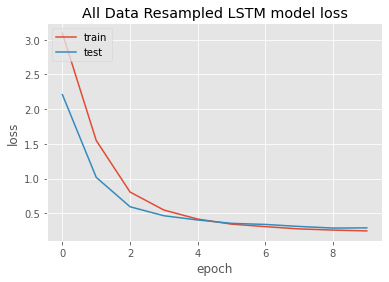

In [75]:
lstmModelAllDataResampled.plotModelAccuracy(lstmModelAllDataResampled_history, 'All Data Resampled LSTM')

#### Dataframe result capture

In [76]:
results=pd.DataFrame()
pred_results = pd.DataFrame()
results=captureData(results,lstmModelRawData_history,'LSTM model_WV_rawdata','LSTM+Word2Vec Embedding on raw data','1',0)
pred_results= capturePrediction(pred_results,'LSTM model_WV_rawdata','LSTM+Word2Vec Embedding on raw data','1',rawData_accuracy,0)

In [77]:
results=captureData(results,lstmModelAllDataResampled_history,'LSTM model_WV_resampled data','LSTM+Word2Vec Embedding on Augmented data','2',0)
pred_results= capturePrediction(pred_results,'LSTM model_WV_resampled data','LSTM+Word2Vec Embedding on Augmented data','2',resampled_accuracy,0)

In [78]:
from tensorflow import keras
from keras.models import load_model
model.save('lstm-model-resampled-1.h5')

### LSTM two part model

In [ ]:
class TwoModel:

  model_1 = Model()
  model_2 = Model()
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return tokenizer,dataframe

  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, X_test, y_train, y_test, X_Val, y_Val

  def runFirstModel(self,dataframe,epochs):

    grp0_df = dataframe.copy()
    grp0_df['Assignment group']=dataframe['Assignment group'].apply(lambda x : 1 if x != 0  else x)
    tokenizer,X = self.wordTokenizer(grp0_df['Description'])
    y = np.asarray(grp0_df['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)

    model_history,self.model_1 = self.modelRunner(X_train,y_train,X_Val,y_Val,epochs)
    return model_history,self.model_1

  def runSecondModel(self, dataframe,epochs):

    grpOthers_df = dataframe.copy()
    grpOthers_df = grpOthers_df[grpOthers_df['Assignment group'] != 0]
    grpOthers_df['Assignment group']=grpOthers_df['Assignment group'] - 1
    tokenizer,X = self.wordTokenizer(grpOthers_df['Description'])
    y = np.asarray(grpOthers_df['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
      
    model_history,self.model_2 = self.modelRunner(X_train,y_train,X_Val,y_Val,epochs)
    return model_history,self.model_2

  def modelRunner(self, X,Y,X_Val,Y_Val,epochs):
        
        input_layer = Input(shape=(maxlen,),dtype=tf.int64)
        embed = Embedding(input_dim = numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #
        lstm=Bidirectional(LSTM(128))(embed)
        drop=Dropout(0.3)(lstm)
        dense =Dense(100,activation='relu')(drop)
        out=Dense(len((pd.Series(Y)).unique()),activation='softmax')(dense)   
        batch_size = 100
        
        model = Model(input_layer,out)
        model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
        
        checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
        reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
        
        model_history = model.fit(X,Y,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,Y_Val))
        return model_history,model

  def predict(self, X_test):
        predBinary = self.model_1.predict(X_test)
        predBinary = [1 if j>i else 0 for i,j in predBinary]

        new_X_test = pd.DataFrame(X_test)
        new_X_test['grp']=predBinary
        sec_input = new_X_test[new_X_test['grp']!=0]
        sec_input.drop(['grp'],inplace=True, axis=1)
        new_X_test=new_X_test[new_X_test['grp']==0]

        predOther = self.model_2.predict(sec_input)
        predOther = [i.argmax() for i in predOther]
        predOther= [i+1 for i in predOther]
        sec_input['grp']=predOther

        pred_df = pd.concat([new_X_test,sec_input])
        pred_df.sort_index(axis=0,inplace=True)

        return np.array(pred_df['grp'])

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


In [ ]:
model = TwoModel()
model1_history,_ = model.runFirstModel(otherGrpsResampled,5)
model2_history,_ = model.runSecondModel(otherGrpsResampled,20)

tokenizer,X = model.wordTokenizer(otherGrpsResampled['Description'])
y = np.asarray(otherGrpsResampled['Assignment group'])
X = pad_sequences(X, maxlen = maxlen)
_, X_test, _, y_test, _, _ = model.splitData(X,y)

predictions = model.predict(X_test)
twoModel_sampledAccuracy = metrics.accuracy_score(y_test, predictions)
print("Accuracy:",twoModel_sampledAccuracy)

Number of Samples: 24609
Number of Labels:  24609
Number of train Samples: 19687
Number of val Samples: 4922
Epoch 1/5
197/197 [==============================] - ETA: 0s - loss: 0.3320 - accuracy: 0.8684
Epoch 00001: val_accuracy improved from -inf to 0.88663, saving model to model-001-0.886631.h5
197/197 [==============================] - 373s 2s/step - loss: 0.3320 - accuracy: 0.8684 - val_loss: 0.2677 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 2/5
197/197 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9158
Epoch 00002: val_accuracy improved from 0.88663 to 0.91690, saving model to model-002-0.916904.h5
197/197 [==============================] - 368s 2s/step - loss: 0.2052 - accuracy: 0.9158 - val_loss: 0.2078 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 3/5
197/197 [==============================] - ETA: 0s - loss: 0.1236 - accuracy: 0.9520
Epoch 00003: val_accuracy improved from 0.91690 to 0.93316, saving model to model-003-0.933157.h5
197/197 [================

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 0.27813896789922793


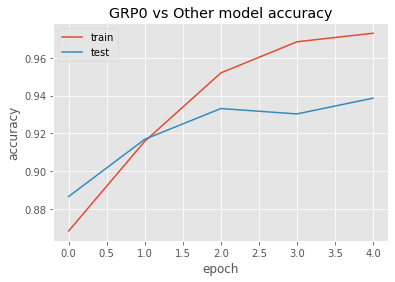

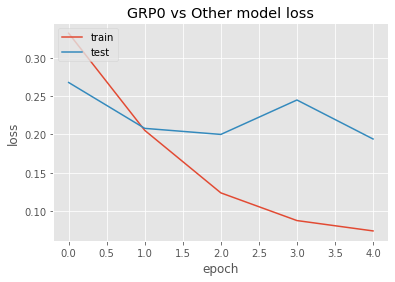

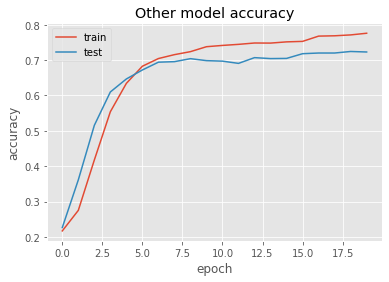

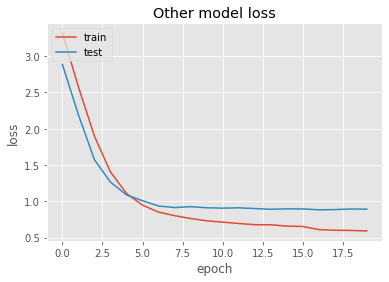

In [ ]:
model.plotModelAccuracy(model1_history, 'GRP0 vs Other')
model.plotModelAccuracy(model2_history, 'Other')

#### Dataframe result capture

In [ ]:
results=captureData(results,model1_history,'LSTM 2 part model_WV_grp0','LSTM+Word2Vec Embedding on grp0_data','3',0)
results=captureData(results,model2_history,'LSTM 2 part model_WV_Others','LSTM+Word2Vec Embedding on Rest of groups','4',0)
pred_results= capturePrediction(pred_results,'LSTM 2 part model_WV','LSTM+Word2Vec Embedding on Augmented data','3',twoModel_sampledAccuracy,0)

## Glove embedding

In [ ]:
#download the glove embedding from https://nlp.stanford.edu/projects/glove/
#glove_file = "/content/drive/My Drive/ML_Project/NLP/NLP-1 Sentiment Classification/" + "glove.6B.zip"
glove_file = project_path + "glove.6B.zip"
print(glove_file)

/content/drive/My Drive/Capstone_NLP/glove.6B.zip


In [ ]:
#Extract Glove embedding zip file
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [ ]:
# EMBEDDING_FILE = './glove.6B.200d.txt'
EMBEDDING_FILE = './glove.6B.100d.txt'
embeddings_glove = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    #print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    #print(embd)
    embeddings_glove[word] = embd

In [ ]:
print("Dimension of the embedding vector is {}".format(len(embeddings_glove["collaboration"])))
print("Dimension of the embedding vector is {}".format(len(embeddings_glove["platform"])))

Dimension of the embedding vector is 100
Dimension of the embedding vector is 100


In [ ]:
maxlen = 300
numWords=9000
epochs = 10

### LSTM Model

In [ ]:
class LstmGloveModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_glove.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    lstm=Bidirectional(LSTM(128))(embed)
    drop=Dropout(0.3)(lstm)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))
    return model_history,self.model

  def prediction(self):
      
     pred = self.model.predict(self.X_test)
     pred = [i.argmax() for i in pred]
     accuracy = metrics.accuracy_score(self.y_test, pred)
     print("Accuracy of the model :",accuracy)
     return accuracy

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [ ]:
# Check how the LSTM Model perform with the cleansed data
# Check how the LSTM Model perform with the cleansed data
lstmModelRawData = LstmGloveModel()
lstmModelRawData_history, model = lstmModelRawData.train(itTicketDF,100,epochs)
lstm_raw_accuracy = lstmModelRawData.prediction()

Number of Samples: 8439
Number of Labels:  8439
Number of train Samples: 6751
Number of val Samples: 1688
Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 2.5581 - accuracy: 0.4835
Epoch 00001: val_accuracy improved from -inf to 0.52784, saving model to model-001-0.527844.h5
68/68 [==============================] - 124s 2s/step - loss: 2.5581 - accuracy: 0.4835 - val_loss: 2.1102 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 1.9681 - accuracy: 0.5466
Epoch 00002: val_accuracy improved from 0.52784 to 0.56339, saving model to model-002-0.563389.h5
68/68 [==============================] - 123s 2s/step - loss: 1.9681 - accuracy: 0.5466 - val_loss: 1.9042 - val_accuracy: 0.5634 - lr: 0.0010
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 1.7513 - accuracy: 0.5750
Epoch 00003: val_accuracy improved from 0.56339 to 0.56754, saving model to model-003-0.567536.h5
68/68 [============================

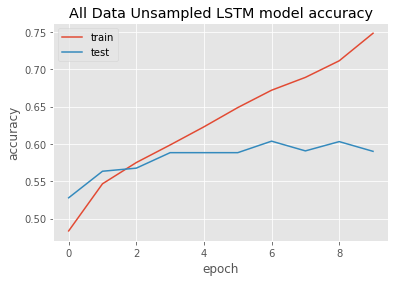

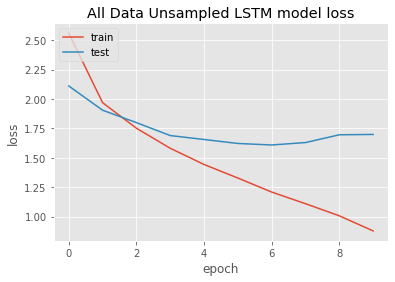

In [ ]:
lstmModelRawData.plotModelAccuracy(lstmModelRawData_history, 'All Data Unsampled LSTM')

In [ ]:
#Check how the LSTM Model perform with all the data which is cleansed & resampled to 661 to make the target balance
lstmModelAllDataResampled = LstmGloveModel()
lstmModelAllDataResampled_history, model = lstmModelAllDataResampled.train(itTicketDF_resampled,100,epochs)
lstm_allResampled_accuracy = lstmModelAllDataResampled.prediction()

Number of Samples: 33050
Number of Labels:  33050
Number of train Samples: 26440
Number of val Samples: 6610
Epoch 1/10
265/265 [==============================] - ETA: 0s - loss: 2.5982 - accuracy: 0.3193
Epoch 00001: val_accuracy improved from -inf to 0.62209, saving model to model-001-0.622088.h5
265/265 [==============================] - 495s 2s/step - loss: 2.5982 - accuracy: 0.3193 - val_loss: 1.3839 - val_accuracy: 0.6221 - lr: 0.0010
Epoch 2/10
265/265 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.7092
Epoch 00002: val_accuracy improved from 0.62209 to 0.79198, saving model to model-002-0.791982.h5
265/265 [==============================] - 494s 2s/step - loss: 1.0567 - accuracy: 0.7092 - val_loss: 0.7536 - val_accuracy: 0.7920 - lr: 0.0010
Epoch 3/10
265/265 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.8224
Epoch 00003: val_accuracy improved from 0.79198 to 0.85930, saving model to model-003-0.859304.h5
265/265 [=============

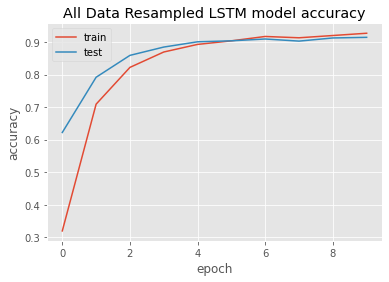

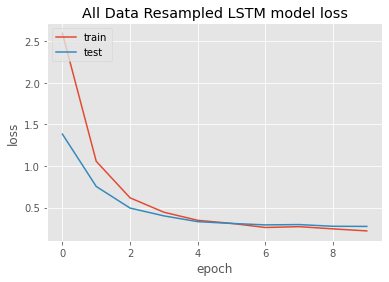

In [ ]:
lstmModelAllDataResampled.plotModelAccuracy(lstmModelAllDataResampled_history, 'All Data Resampled LSTM')

#### Dataframe result capture

In [ ]:
results=captureData(results,lstmModelRawData_history,'LSTM model_GloVe_rawdata','LSTM+GloVe Embedding on raw data','5',0)
pred_results= capturePrediction(pred_results,'LSTM model_GloVe_rawdata','LSTM+GloVe Embedding on raw data','4',lstm_raw_accuracy,0)

In [ ]:
results=captureData(results,lstmModelAllDataResampled_history,'LSTM model_GloVe_resampled data','LSTM+GloVe Embedding on Augmented data','6',0)
pred_results= capturePrediction(pred_results,'LSTM model_GloVe_resampled data','LSTM+GloVe Embedding on Augmented data','5',lstm_allResampled_accuracy,0)

### GRU Model

In [ ]:
class GruGloveModel:
  model= Model()
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe
  
  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def train(self, dataframe, batch_size, epochs):
   
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)
    model_history = self.fitModel(X_train,y_train,X_Val,y_Val,batch_size, epochs)
    return model_history

  def fitModel(self,X_train,y_train,X_Val,y_Val,batch_size, epochs):
    
    input_layer = Input(shape=(maxlen,),dtype=tf.int64)
    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)(input_layer)  #weights=[embedding_matrix]
    gru=GRU(128)(embed)
    drop=Dropout(0.3)(gru)
    dense =Dense(100,activation='relu')(drop)
    out=Dense(len((pd.Series(y_train)).unique()),activation='softmax')(dense)   

    self.model = Model(input_layer,out)
    self.model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    # self.model.summary()
    # plot_model(self.model,to_file="GRU.jpg")

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = self.model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val,y_Val))
    return model_history,self.model

  def prediction(self):
      
     pred = self.model.predict(self.X_test)
     pred = [i.argmax() for i in pred]
     accuracy=metrics.accuracy_score(self.y_test, pred)
     print("Accuracy of the model :",accuracy)
     return accuracy

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

  def plotModel(self):
    self.model.summary()

In [ ]:
# Check how the GRU Model perform with the cleansed data
# Check how the LSTM Model perform with the cleansed data
gruModelRawData = GruGloveModel()
gruModelRawData_history, model = gruModelRawData.train(itTicketDF,100,epochs)
gruRaw_accuracy = gruModelRawData.prediction()

Number of Samples: 8439
Number of Labels:  8439
Number of train Samples: 6751
Number of val Samples: 1688
Epoch 1/10
68/68 [==============================] - ETA: 0s - loss: 2.5058 - accuracy: 0.4974
Epoch 00001: val_accuracy improved from -inf to 0.52784, saving model to model-001-0.527844.h5
68/68 [==============================] - 52s 763ms/step - loss: 2.5058 - accuracy: 0.4974 - val_loss: 2.1237 - val_accuracy: 0.5278 - lr: 0.0010
Epoch 2/10
68/68 [==============================] - ETA: 0s - loss: 2.0482 - accuracy: 0.5410
Epoch 00002: val_accuracy improved from 0.52784 to 0.53614, saving model to model-002-0.536137.h5
68/68 [==============================] - 52s 759ms/step - loss: 2.0482 - accuracy: 0.5410 - val_loss: 1.9495 - val_accuracy: 0.5361 - lr: 0.0010
Epoch 3/10
68/68 [==============================] - ETA: 0s - loss: 1.8435 - accuracy: 0.5570
Epoch 00003: val_accuracy improved from 0.53614 to 0.56398, saving model to model-003-0.563981.h5
68/68 [========================

In [ ]:
gruModelRawData.plotModel()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 300, 100)          900100    
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               12900     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
Total params: 1,006,370
Trainable params: 1,006,370
Non-trainable params: 0
________________________________________________

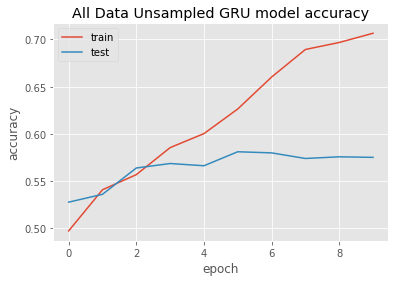

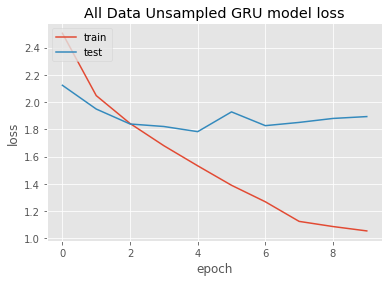

In [ ]:
gruModelRawData.plotModelAccuracy(gruModelRawData_history, 'All Data Unsampled GRU')

In [ ]:
# Check how the GRU Model perform with all the data which is cleansed & resampled to 661 to make the target balance
gruModelAllDataResampled = GruGloveModel()
gruModelAllDataResampled_history, model = gruModelAllDataResampled.train(itTicketDF_resampled,100,epochs)
gruResampled_accuracy = gruModelAllDataResampled.prediction()

Number of Samples: 33050
Number of Labels:  33050
Number of train Samples: 26440
Number of val Samples: 6610
Epoch 1/10
265/265 [==============================] - ETA: 0s - loss: 3.0668 - accuracy: 0.1906
Epoch 00001: val_accuracy improved from -inf to 0.47973, saving model to model-001-0.479728.h5
265/265 [==============================] - 206s 778ms/step - loss: 3.0668 - accuracy: 0.1906 - val_loss: 1.9527 - val_accuracy: 0.4797 - lr: 0.0010
Epoch 2/10
265/265 [==============================] - ETA: 0s - loss: 1.3162 - accuracy: 0.6381
Epoch 00002: val_accuracy improved from 0.47973 to 0.79349, saving model to model-002-0.793495.h5
265/265 [==============================] - 207s 782ms/step - loss: 1.3162 - accuracy: 0.6381 - val_loss: 0.7810 - val_accuracy: 0.7935 - lr: 0.0010
Epoch 3/10
265/265 [==============================] - ETA: 0s - loss: 0.6177 - accuracy: 0.8300
Epoch 00003: val_accuracy improved from 0.79349 to 0.86520, saving model to model-003-0.865204.h5
265/265 [=======

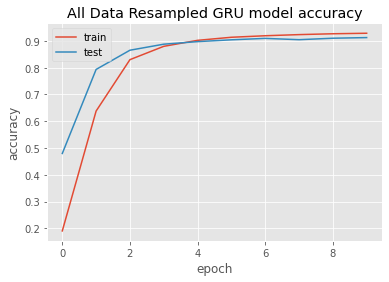

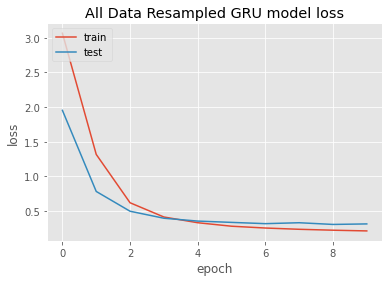

In [ ]:
gruModelAllDataResampled.plotModelAccuracy(gruModelAllDataResampled_history, 'All Data Resampled GRU')

#### Dataframe result capture

In [ ]:
results=captureData(results,gruModelRawData_history,'GRU model_GloVe_rawdata','GRU+GloVe Embedding on raw data','7',0)
pred_results= capturePrediction(pred_results,'GRU model_GloVe_rawdata','GRU+GloVe Embedding on raw data','6',gruRaw_accuracy,0)

In [ ]:
results=captureData(results,gruModelAllDataResampled_history,'GRU model_GloVe_resampled data','GRU+GloVe Embedding on Augmented data','8',0)
pred_results= capturePrediction(pred_results,'GRU model_GloVe_resampled data','GRU+GloVe Embedding on Augmented data','7',gruResampled_accuracy,0)

### RNN Model 

In [ ]:
class RNNGloveModel:
  X_test=[]
  y_test=[]
  embedding_matrix=[]

  def wordTokenizer(self, dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

  def tokenizeAndEmbedding(self,dataframe):
    
    tokenizer,X = self.wordTokenizer(dataframe['Description'])
    y = np.asarray(dataframe['Assignment group'])
    X = pad_sequences(X, maxlen = maxlen)

    self.embedding_matrix = np.zeros((numWords+1, 100))
    for i,word in tokenizer.index_word.items():
      if i<numWords+1:
        embedding_vector = embeddings_glove.get(word)
        if embedding_vector is not None:
            self.embedding_matrix[i] = embedding_vector
    return X,y

  def splitData(self,X,y):

    print("Number of Samples:", len(X))
    print("Number of Labels: ", len(y))
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=10) # changed by Abraham
    X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=0.2, random_state=10)
    print("Number of train Samples:", len(X_train))
    print("Number of val Samples:", len(X_Val))

    return X_train, self.X_test, y_train, self.y_test, X_Val, y_Val

  def train(self, dataframe, batch_size, epochs):
    X,y = self.tokenizeAndEmbedding(dataframe)
    X_train, _, y_train, _, X_Val, y_Val = self.splitData(X,y)

    embed = Embedding(numWords+1,output_dim=100,input_length=maxlen,weights=[self.embedding_matrix], trainable=True)
    model=Sequential()
    model.add(Input(shape=(maxlen,),dtype=tf.int64))
    model.add(embed)
    model.add(Conv1D(100,10,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))
    model.add(Conv1D(100,10,activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Bidirectional(LSTM(128)))
    model.add(Dropout(0.3))
    model.add(Dense(100,activation='relu'))
    model.add(Dense(len((pd.Series(y_train)).unique()),activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

    model.summary()
    plot_model(model,to_file="RNN.jpg")

    checkpoint = ModelCheckpoint('model-{epoch:03d}-{val_accuracy:03f}.h5', verbose=1, monitor='val_accuracy',save_best_only=True, mode='auto') 
    reduceLoss = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.0001)
    model_history = model.fit(X_train,y_train,batch_size=batch_size, epochs=epochs, callbacks=[checkpoint,reduceLoss], validation_data=(X_Val, y_Val))
    return model_history, model

  def prediction(self,model):
      
     pred = model.predict(self.X_test)
     pred = [i.argmax() for i in pred]
     accuracy = metrics.accuracy_score(self.y_test, pred)
     print("Accuracy of the model :",accuracy)
     return accuracy

  def plotModelAccuracy(self, history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

In [ ]:
# Check how the RNN Model perform with the cleansed data
RNNModelRawData = RNNGloveModel()
RNNModelRawData_history, RnnModel = RNNModelRawData.train(itTicketDF,100,epochs)
RNNModelRawData_accuracy = RNNModelRawData.prediction(RnnModel)

Number of Samples: 8439
Number of Labels:  8439
Number of train Samples: 6751
Number of val Samples: 1688
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 300, 100)          900100    
_________________________________________________________________
conv1d (Conv1D)              (None, 291, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 145, 100)          0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 145, 100)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 136, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 68, 100)           0         
________________

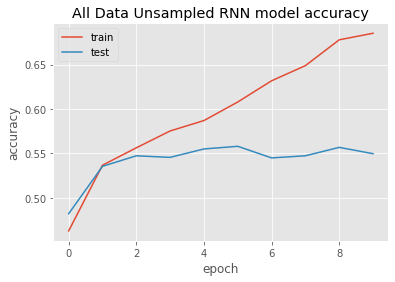

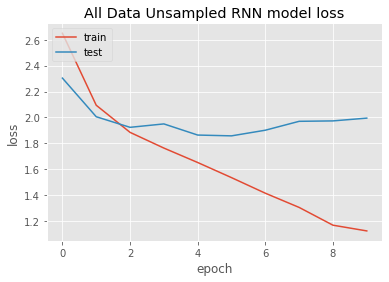

In [ ]:
RNNModelRawData.plotModelAccuracy(RNNModelRawData_history, 'All Data Unsampled RNN')

In [ ]:
#Check how the RNN Model perform with all the data which is cleansed & resampled to 661 to make the target balance
RNNModelAllDataResampled = RNNGloveModel()
RNNModelAllDataResampled_history, RnnModel = RNNModelAllDataResampled.train(itTicketDF_resampled,100,epochs)
RNNModelResampled_accuracy = RNNModelAllDataResampled.prediction(RnnModel)

Number of Samples: 33050
Number of Labels:  33050
Number of train Samples: 26440
Number of val Samples: 6610
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 300, 100)          900100    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 291, 100)          100100    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 145, 100)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 145, 100)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 136, 100)          100100    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 68, 100)           0         
___________

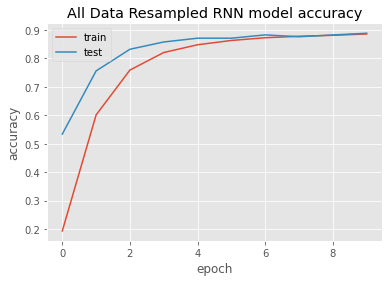

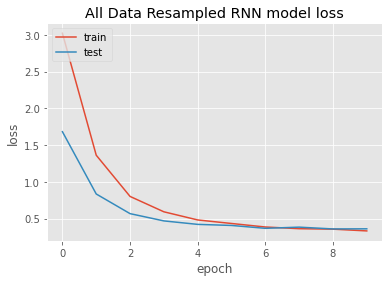

In [ ]:
RNNModelAllDataResampled.plotModelAccuracy(RNNModelAllDataResampled_history, 'All Data Resampled RNN')

#### Dataframe result capture

In [ ]:
# results=pd.DataFrame()
results=captureData(results,RNNModelRawData_history,'RNN model_GloVe_rawdata','RNN+GloVe Embedding on raw data','9',0)
pred_results= capturePrediction(pred_results,'RNN model_GloVe_rawdata','RNN+GloVe Embedding on raw data','8',RNNModelRawData_accuracy,0)

In [ ]:
results=captureData(results,RNNModelAllDataResampled_history,'RNN model_GloVe_resampled data','RNN+GloVe Embedding on Augmented data','10',0)
pred_results= capturePrediction(pred_results,'RNN model_GloVe_resampled data','RNN+GloVe Embedding on Augmented data','9',RNNModelResampled_accuracy,0)

In [ ]:
results

model  ...                               descriptions
1             LSTM model_WV_rawdata  ...        LSTM+Word2Vec Embedding on raw data
2      LSTM model_WV_resampled data  ...  LSTM+Word2Vec Embedding on Augmented data
3         LSTM 2 part model_WV_grp0  ...       LSTM+Word2Vec Embedding on grp0_data
4       LSTM 2 part model_WV_Others  ...  LSTM+Word2Vec Embedding on Rest of groups
5          LSTM model_GloVe_rawdata  ...           LSTM+GloVe Embedding on raw data
6   LSTM model_GloVe_resampled data  ...     LSTM+GloVe Embedding on Augmented data
7           GRU model_GloVe_rawdata  ...            GRU+GloVe Embedding on raw data
8    GRU model_GloVe_resampled data  ...      GRU+GloVe Embedding on Augmented data
9           RNN model_GloVe_rawdata  ...            RNN+GloVe Embedding on raw data
10   RNN model_GloVe_resampled data  ...      RNN+GloVe Embedding on Augmented data

[10 rows x 6 columns]

In [ ]:
pred_results

model  ...                               descriptions
1            LSTM model_WV_rawdata  ...        LSTM+Word2Vec Embedding on raw data
2     LSTM model_WV_resampled data  ...  LSTM+Word2Vec Embedding on Augmented data
3             LSTM 2 part model_WV  ...  LSTM+Word2Vec Embedding on Augmented data
4         LSTM model_GloVe_rawdata  ...           LSTM+GloVe Embedding on raw data
5  LSTM model_GloVe_resampled data  ...     LSTM+GloVe Embedding on Augmented data
6          GRU model_GloVe_rawdata  ...            GRU+GloVe Embedding on raw data
7   GRU model_GloVe_resampled data  ...      GRU+GloVe Embedding on Augmented data
8          RNN model_GloVe_rawdata  ...            RNN+GloVe Embedding on raw data
9   RNN model_GloVe_resampled data  ...      RNN+GloVe Embedding on Augmented data

[9 rows x 3 columns]

## Traditional ML/Random forest

#### Observation:
 - Random Forest Model using raw data seems to perform better as compared to Random Forest Model with PCA done.
 - It also affirm the understanding that PCA uses linearity in the data to reduce dimensionality, where as the problems such NLP uses the non-linearity of feature.


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def wordTokenizer(dataframe):
    tokenizer = Tokenizer(num_words=numWords,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
    tokenizer.fit_on_texts(dataframe)
    dataframe = tokenizer.texts_to_sequences(dataframe)
    return tokenizer,dataframe

In [ ]:
maxlen = 150
numWords = 9000
tokenizer,X = wordTokenizer(itTicketDF['Description'])
y = np.asarray(itTicketDF['Assignment group'])
X = pad_sequences(X, maxlen = maxlen)

print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Number of train Samples:", len(X_train))
print("Number of val Samples:", len(X_test))

Number of Samples: 8439
Number of Labels:  8439
Number of train Samples: 6751
Number of val Samples: 1688


### Random Forest Model on the Raw data

In [ ]:
rawClf=RandomForestClassifier(n_estimators=100)
rawClf.fit(X_train,y_train)
y_pred=rawClf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5758293838862559


In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
results_ml=pd.DataFrame()
tempResultsDf_ml = pd.DataFrame({'Model':['Random Forest'], 'accuracy': [metrics.accuracy_score(y_test, y_pred)]},index={'1'})
results_ml = pd.concat([results_ml, tempResultsDf_ml])
results_ml

Model  accuracy
1  Random Forest  0.575829

### SVM Classifier model

In [ ]:
Cs = [0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}
svc = svm.SVC(kernel='rbf')
grid_search = GridSearchCV(svc, param_grid)
grid_search.fit(X_train,y_train)

clf = svm.SVC(**grid_search.best_params_)
clf.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.5562796208530806

In [ ]:
#Store the accuracy results for each model in a dataframe for final comparison
tempResultsDf_ml = pd.DataFrame({'Model':['SVM Classifier'], 'accuracy': [metrics.accuracy_score(y_test, y_pred)]},index={'2'})
results_ml = pd.concat([results_ml, tempResultsDf_ml])
results_ml

Model  accuracy
1   Random Forest  0.575829
2  SVM Classifier  0.556280